# Planning

## Challenge

As a data scientist at a hotel chain, I'm trying to find out what customers are happy and unhappy with, based on reviews. I'd like to know the topics in each review and a score for the topic.

## Approach

- Use standard NLP techniques (tokenization, TF-IDF, etc.) to process the reviews
- Use LDA to identify topics in the reviews for each hotel
    - Learn the topics from whole reviews
    - For each hotel, combine all of the reviews into a metareview
    - Use the fit LDA model to score the appropriateness of each topic for this hotel
    - Also across all hotels
- Look at topics coming up in happy vs. unhappy reviews for each hotel

## Results


## Takeaways


In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import pyLDAvis  # Has a warning on import
import pyLDAvis.sklearn
import pyLDAvis.gensim
import seaborn as sns

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, Phrases, TfidfModel  # Has a warning on import
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import display
from nltk.corpus import stopwords  # Has a warning on import
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
regex_tokenizer = RegexpTokenizer(r'\w+')
vader_analyzer = SentimentIntensityAnalyzer()

unable to import 'smart_open.gcs', disabling that module


/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working

/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.

/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working

/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/nltk/decorators.py:67: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and t

In [2]:
# Plot settings
sns.set(style="whitegrid", font_scale=1.10)
pio.templates.default = "plotly_white"

In [3]:
# Set random number seed for reproducibility
np.random.seed(48)

In [4]:
# Set logging level for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [5]:
data_dir = '~/devel/insight-data-challenges/07-happy-hotel/data'
output_dir = '~/devel/insight-data-challenges/07-happy-hotel/output'

## Read in and clean the data

Before reading in all of the files I downloaded from the GDrive, I used `diff` to compare the files because they looked like they might be duplicates. 

```
diff hotel_happy_reviews\ -\ hotel_happy_reviews.csv hotel_happy_reviews\ -\ hotel_happy_reviews.csv.csv
diff hotel_happy_reviews\ -\ hotel_happy_reviews.csv hotel_happy_reviews(1)\ -\ hotel_happy_reviews.csv
```

This indicated that three of the files were exact duplicates, leaving me with one file of happy reviews and one file of not happy reviews.
```
hotel_happy_reviews - hotel_happy_reviews.csv
hotel_not_happy_reviews - hotel_not_happy_reviews.csv.csv
```

In [6]:
happy_reviews = pd.read_csv(
    os.path.join(os.path.expanduser(data_dir), 'hotel_happy_reviews - hotel_happy_reviews.csv'),
)
display(happy_reviews.info())
display(happy_reviews)

# Name this bad_reviews so it's easier to distinguish
bad_reviews = pd.read_csv(
    os.path.join(os.path.expanduser(data_dir), 'hotel_not_happy_reviews - hotel_not_happy_reviews.csv.csv'),
)
display(bad_reviews.info())
display(bad_reviews)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26521 entries, 0 to 26520
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      26521 non-null  object
 1   Description  26521 non-null  object
 2   Is_Response  26521 non-null  object
 3   hotel_ID     26521 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 828.9+ KB


None

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3
...,...,...,...,...
26516,id49247,We staed at the Handlery Hotel to Visit San Di...,happy,5
26517,id49250,We booked a room with two single beds. Upon ar...,happy,3
26518,id49251,Arrived via taxi from La Guardia - driving int...,happy,8
26519,id49253,We arrived late at night and walked in to a ch...,happy,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      12411 non-null  object
 1   Description  12411 non-null  object
 2   Is_Response  12411 non-null  object
 3   hotel_ID     12411 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 388.0+ KB


None

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7
...,...,...,...,...
12406,id49249,I am pretty impartial to this hotel. I would d...,not happy,2
12407,id49252,I tend to post reviews only when I’ve had an e...,not happy,1
12408,id49254,The only positive impression is location and p...,not happy,2
12409,id49255,Traveling with friends for shopping and a show...,not happy,5


### Check that the two dfs are formatted the same

In [7]:
assert happy_reviews.columns.to_list() == bad_reviews.columns.to_list()
assert happy_reviews.dtypes.to_list() == bad_reviews.dtypes.to_list()

## Look at the data in detail

In [8]:
display(happy_reviews['hotel_ID'].value_counts())
display(happy_reviews['User_ID'].describe())

display(bad_reviews['hotel_ID'].value_counts())
display(bad_reviews['User_ID'].describe())

5     5540
4     4651
8     4503
3     3470
7     3019
1     2179
2     1046
6      823
10     777
9      513
Name: hotel_ID, dtype: int64

count       26521
unique      26521
top       id30168
freq            1
Name: User_ID, dtype: object

7     2298
4     2196
1     1750
3     1612
5     1142
2     1012
8      850
10     734
9      483
6      334
Name: hotel_ID, dtype: int64

count       12411
unique      12411
top       id15256
freq            1
Name: User_ID, dtype: object

## Process review text

### Tokenize

Split the reviews up into individual words

In [9]:
def tokenize(review):
    '''Split review string into tokens; remove stop words.

    Returns: list of strings, one for each word in the review
    '''
    s = review.lower()  # Make lowercase
    s = regex_tokenizer.tokenize(s)  # Split into words and remove punctuation.
    s = [t for t in s if not t.isnumeric()]  # Remove numbers but not words containing numbers.
    s = [t for t in s if len(t) > 2]  # Remove 1- and 2-character tokens.
    # I found that the lemmatizer didn't work very well here - it needs a little more tuning to be useful.
    # For example, "was" and "has" were lemmatized to "wa" and "ha", which was counterproductive.
    s = [stemmer.stem(lemmatizer.lemmatize(t, pos='v')) for t in s]  # Stem and lemmatize verbs
    s = [t for t in s if t not in STOPWORDS]  # Remove stop words
    return s


happy_tokens = happy_reviews['Description'].apply(tokenize)
bad_tokens = bad_reviews['Description'].apply(tokenize)

display(happy_tokens.head())
display(bad_tokens.head())

all_tokens = happy_tokens.append(bad_tokens, ignore_index=True)

0    [stay, husband, son, way, alaska, cruis, love,...
1    [room, veri, nice, clear, updat, recent, clean...
2    [wife, stay, glorious, citi, expens, littl, ho...
3    [boyfriend, stay, fairmont, recent, trip, san,...
4    [step, time, squar, nice, room, stay, night, g...
Name: Description, dtype: object

0    [room, kind, clean, veri, strong, smell, dog, ...
1    [stay, crown, plaza, april, april, staff, frie...
2    [book, hotel, hotwir, lowest, price, desk, man...
3    [girlfriend, stay, celebr, birthday, plan, wee...
4    [husband, stay, hotel, time, fanciest, hotel, ...
Name: Description, dtype: object

### Find bigrams and trigrams

Identify word pairs and triplets that are above a given count threshold across all reviews.

In [10]:
# Add bigrams to single tokens
bigrammer = Phrases(all_tokens, min_count=20)
trigrammer = Phrases(bigrammer[all_tokens], min_count=20)

# For bigrams and trigrams meeting the min and threshold, add them to the token lists.
for idx in range(len(all_tokens)):
    all_tokens.iloc[idx].extend([token for token in trigrammer[all_tokens.iloc[idx]]
                                 if '_' in token])  # Bigrams and trigrams are joined by underscores

2020-04-09 15:31:27,829 : INFO : collecting all words and their counts


2020-04-09 15:31:27,830 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


2020-04-09 15:31:28,867 : INFO : PROGRESS: at sentence #10000, processed 649419 words and 293252 word types


2020-04-09 15:31:29,875 : INFO : PROGRESS: at sentence #20000, processed 1287661 words and 482633 word types


2020-04-09 15:31:31,066 : INFO : PROGRESS: at sentence #30000, processed 1997293 words and 678079 word types


2020-04-09 15:31:32,213 : INFO : collected 867532 word types from a corpus of 2709042 words (unigram + bigrams) and 38932 sentences


2020-04-09 15:31:32,214 : INFO : using 867532 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>


2020-04-09 15:31:32,215 : INFO : collecting all words and their counts


2020-04-09 15:31:32,216 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


2020-04-09 15:31:35,351 : INFO : PROGRESS: at sentence #10000, processed 606772 words and 315749 word types


2020-04-09 15:31:38,483 : INFO : PROGRESS: at sentence #20000, processed 1203563 words and 527931 word types


2020-04-09 15:31:42,095 : INFO : PROGRESS: at sentence #30000, processed 1870929 words and 747100 word types


2020-04-09 15:31:45,646 : INFO : collected 958543 word types from a corpus of 2546778 words (unigram + bigrams) and 38932 sentences


2020-04-09 15:31:45,647 : INFO : using 958543 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>


### Remove rare and common tokens, and limit vocabulary

2020-04-09 15:31:55,317 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


2020-04-09 15:31:56,044 : INFO : adding document #10000 to Dictionary(16941 unique tokens: ['alaska', 'ask', 'bed', 'best', 'citi']...)


2020-04-09 15:31:56,765 : INFO : adding document #20000 to Dictionary(23009 unique tokens: ['alaska', 'ask', 'bed', 'best', 'citi']...)


2020-04-09 15:31:57,550 : INFO : adding document #30000 to Dictionary(28218 unique tokens: ['alaska', 'ask', 'bed', 'best', 'citi']...)


2020-04-09 15:31:58,319 : INFO : built Dictionary(32557 unique tokens: ['alaska', 'ask', 'bed', 'best', 'citi']...) from 38932 documents (total 2894621 corpus positions)


2020-04-09 15:31:58,350 : INFO : discarding 27399 tokens: [('hotel', 30328), ('room', 31925), ('stay', 26809), ('bwi', 11), ('oriol', 29), ('supershuttl', 11), ('veri', 21960), ('wrinkl', 23), ('scorpion', 4), ('tonga', 17)]...


2020-04-09 15:31:58,351 : INFO : keeping 5158 tokens which were in no less than 30 and no more than 19466 (=50.0%) documents


2020-04-09 15:31:58,359 : DEBUG : rebuilding dictionary, shrinking gaps


2020-04-09 15:31:58,367 : INFO : resulting dictionary: Dictionary(5158 unique tokens: ['alaska', 'ask', 'bed', 'best', 'citi']...)


2020-04-09 15:31:58,474 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.100000000000001.


2020-04-09 15:31:58,474 : DEBUG : findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,475 : DEBUG : findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,476 : DEBUG : findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,476 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,477 : DEBUG : findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,477 : DEBUG : findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,478 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,478 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,479 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,479 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,480 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335


2020-04-09 15:31:58,480 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,481 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,481 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,482 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05


2020-04-09 15:31:58,482 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,483 : DEBUG : findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,483 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 2.335


2020-04-09 15:31:58,483 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,484 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,484 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,485 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,485 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,486 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,486 : DEBUG : findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,486 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,487 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,487 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,488 : DEBUG : findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,488 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05


2020-04-09 15:31:58,489 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,489 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,490 : DEBUG : findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,490 : DEBUG : findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,491 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,491 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,492 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,492 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,493 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,493 : DEBUG : findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,493 : DEBUG : findfont: score(<Font 'Adobe Song Std' (AdobeSongStd-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,494 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,494 : DEBUG : findfont: score(<Font 'Lithos Pro' (LithosPro-Black.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:58,495 : DEBUG : findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,495 : DEBUG : findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,495 : DEBUG : findfont: score(<Font 'Stencil Std' (StencilStd.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,496 : DEBUG : findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,496 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Medium.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,497 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,497 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725


2020-04-09 15:31:58,497 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,498 : DEBUG : findfont: score(<Font 'Noto Sans Batak' (NotoSansBatak-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,498 : DEBUG : findfont: score(<Font 'Gulim' (Gulim.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,499 : DEBUG : findfont: score(<Font 'Hobo Std' (HoboStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,499 : DEBUG : findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:58,500 : DEBUG : findfont: score(<Font 'MS Mincho' (MS Mincho.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,500 : DEBUG : findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:58,500 : DEBUG : findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,501 : DEBUG : findfont: score(<Font 'Orator Std' (OratorStd-Slanted.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,501 : DEBUG : findfont: score(<Font 'Birch Std' (BirchStd.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,501 : DEBUG : findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,502 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,502 : DEBUG : findfont: score(<Font 'Serto Urhoy' (SyrCOMUrhoyBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,503 : DEBUG : findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,503 : DEBUG : findfont: score(<Font 'Consolas' (Consolas Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,503 : DEBUG : findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,504 : DEBUG : findfont: score(<Font 'Orator Std' (OratorStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,504 : DEBUG : findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,504 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,505 : DEBUG : findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,505 : DEBUG : findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,506 : DEBUG : findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,506 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,506 : DEBUG : findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,507 : DEBUG : findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,507 : DEBUG : findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,508 : DEBUG : findfont: score(<Font 'Corbel' (Corbel Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,508 : DEBUG : findfont: score(<Font 'Symbol Tiger Expert' (Symbol Tiger Expert.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,508 : DEBUG : findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,509 : DEBUG : findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,509 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,510 : DEBUG : findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,510 : DEBUG : findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,510 : DEBUG : findfont: score(<Font 'Estrangelo Nisibin' (SyrCOMNisibin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,511 : DEBUG : findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,511 : DEBUG : findfont: score(<Font 'Franklin Gothic Medium' (Franklin Gothic Medium Italic.ttf) italic normal medium normal>) = 11.145


2020-04-09 15:31:58,512 : DEBUG : findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,512 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,512 : DEBUG : findfont: score(<Font 'Noto Sans Shavian' (NotoSansShavian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,513 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,513 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,514 : DEBUG : findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,514 : DEBUG : findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,514 : DEBUG : findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,515 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,515 : DEBUG : findfont: score(<Font 'Franklin Gothic Book' (Franklin Gothic Book Italic.ttf) italic normal book normal>) = 11.05


2020-04-09 15:31:58,516 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,516 : DEBUG : findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,516 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,517 : DEBUG : findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,517 : DEBUG : findfont: score(<Font 'System Font' (SFNS.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,517 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-BoldObl.otf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,518 : DEBUG : findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,518 : DEBUG : findfont: score(<Font 'Serto Jerusalem' (SyrCOMJerusalem.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,519 : DEBUG : findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,519 : DEBUG : findfont: score(<Font 'Adobe Fangsong Std' (AdobeFangsongStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,519 : DEBUG : findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,520 : DEBUG : findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,520 : DEBUG : findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,521 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Semibold.otf) normal normal semibold normal>) = 10.24


2020-04-09 15:31:58,521 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,522 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,522 : DEBUG : findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,522 : DEBUG : findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,523 : DEBUG : findfont: score(<Font 'Consolas' (Consolas Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,523 : DEBUG : findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,524 : DEBUG : findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,524 : DEBUG : findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 0.05


2020-04-09 15:31:58,524 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,525 : DEBUG : findfont: score(<Font 'Estrangelo Midyat' (SyrCOMMidyat.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,525 : DEBUG : findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,526 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal light condensed>) = 10.44


2020-04-09 15:31:58,526 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,526 : DEBUG : findfont: score(<Font '.SF Compact Text' (SFCompactText.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,527 : DEBUG : findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,527 : DEBUG : findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,528 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,528 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,528 : DEBUG : findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,529 : DEBUG : findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,529 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,530 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,530 : DEBUG : findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,530 : DEBUG : findfont: score(<Font 'Serto Mardin' (SyrCOMMardin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,531 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25


2020-04-09 15:31:58,531 : DEBUG : findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,532 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,532 : DEBUG : findfont: score(<Font 'Adobe Fan Heiti Std' (AdobeFanHeitiStd-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,532 : DEBUG : findfont: score(<Font 'PMingLiU-ExtB' (PMingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,533 : DEBUG : findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,533 : DEBUG : findfont: score(<Font 'MS PGothic' (MS PGothic.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,533 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,534 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,534 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisri.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,535 : DEBUG : findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,535 : DEBUG : findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,535 : DEBUG : findfont: score(<Font 'Futura' (Futura.ttc) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,536 : DEBUG : findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,536 : DEBUG : findfont: score(<Font 'Serto Jerusalem' (SyrCOMJerusalemItalic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,536 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,537 : DEBUG : findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,537 : DEBUG : findfont: score(<Font 'Serto Jerusalem Outline' (SyrCOMJerusalemOutline.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,538 : DEBUG : findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,538 : DEBUG : findfont: score(<Font '.SF Compact Display' (SFCompactDisplay.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,539 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,539 : DEBUG : findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,539 : DEBUG : findfont: score(<Font 'Batang' (Batang.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,540 : DEBUG : findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,540 : DEBUG : findfont: score(<Font 'Calibri' (Calibri.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,541 : DEBUG : findfont: score(<Font 'Candara' (Candara Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,541 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,542 : DEBUG : findfont: score(<Font 'Farah' (Farah.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,542 : DEBUG : findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24


2020-04-09 15:31:58,542 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Regular.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,543 : DEBUG : findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,543 : DEBUG : findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,544 : DEBUG : findfont: score(<Font 'Noto Sans Buhid' (NotoSansBuhid-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,544 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-BoldExt.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,544 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-MediumIt.otf) italic normal medium normal>) = 11.145


2020-04-09 15:31:58,545 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Semibold.otf) normal normal semibold normal>) = 10.24


2020-04-09 15:31:58,545 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,545 : DEBUG : findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,546 : DEBUG : findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,546 : DEBUG : findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,547 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisr.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,547 : DEBUG : findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,547 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,548 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,548 : DEBUG : findfont: score(<Font 'Sukhumvit Set' (SukhumvitSet.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,549 : DEBUG : findfont: score(<Font '.SF Compact Text' (SFCompactTextItalic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,549 : DEBUG : findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,550 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-CondItalic.otf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:58,550 : DEBUG : findfont: score(<Font 'Adobe Ming Std' (AdobeMingStd-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,551 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,551 : DEBUG : findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,551 : DEBUG : findfont: score(<Font 'Constantia' (Constantia Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,552 : DEBUG : findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,552 : DEBUG : findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,553 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximri.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,553 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,553 : DEBUG : findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,554 : DEBUG : findfont: score(<Font 'Constantia' (Constantia Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,554 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-BoldIt.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,555 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,555 : DEBUG : findfont: score(<Font 'Inconsolata' (Inconsolata.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,555 : DEBUG : findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,556 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,556 : DEBUG : findfont: score(<Font 'Adobe Gothic Std' (AdobeGothicStd-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,557 : DEBUG : findfont: score(<Font 'Bookshelf Symbol 7' (Bookshelf Symbol 7.ttf) normal normal book normal>) = 10.05


2020-04-09 15:31:58,557 : DEBUG : findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,557 : DEBUG : findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,558 : DEBUG : findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,558 : DEBUG : findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,559 : DEBUG : findfont: score(<Font '.SF NS Mono' (SFNSMonoItalic.ttf) italic normal light normal>) = 11.24


2020-04-09 15:31:58,559 : DEBUG : findfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,559 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirri.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,560 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,560 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,561 : DEBUG : findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,562 : DEBUG : findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,562 : DEBUG : findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,563 : DEBUG : findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,563 : DEBUG : findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,563 : DEBUG : findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,564 : DEBUG : findfont: score(<Font 'Adobe Kaiti Std' (AdobeKaitiStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,564 : DEBUG : findfont: score(<Font 'Tiger' (Tiger.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,565 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,565 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-SemiboldItalic.otf) italic normal semibold normal>) = 11.24


2020-04-09 15:31:58,565 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,566 : DEBUG : findfont: score(<Font 'Franklin Gothic Book' (Franklin Gothic Book.ttf) normal normal book normal>) = 10.05


2020-04-09 15:31:58,566 : DEBUG : findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,567 : DEBUG : findfont: score(<Font 'Calibri' (Calibril.ttf) normal normal light normal>) = 10.24


2020-04-09 15:31:58,567 : DEBUG : findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,568 : DEBUG : findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,568 : DEBUG : findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,568 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,569 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,569 : DEBUG : findfont: score(<Font 'Consolas' (Consolas.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,570 : DEBUG : findfont: score(<Font 'Noto Sans Mongolian' (NotoSansMongolian-Regular.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,570 : DEBUG : findfont: score(<Font 'Serto Jerusalem' (SyrCOMJerusalemBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,570 : DEBUG : findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,571 : DEBUG : findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 0.33499999999999996


2020-04-09 15:31:58,571 : DEBUG : findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,572 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,572 : DEBUG : findfont: score(<Font 'Serto Mardin' (SyrCOMMardinBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,572 : DEBUG : findfont: score(<Font 'East Syriac Ctesiphon' (SyrCOMCtesiphon.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,573 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-It.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,573 : DEBUG : findfont: score(<Font 'Constantia' (Constantia.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,574 : DEBUG : findfont: score(<Font 'Brush Script Std' (BrushScriptStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,574 : DEBUG : findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,574 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,575 : DEBUG : findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,575 : DEBUG : findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,575 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold Italic.ttf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:58,576 : DEBUG : findfont: score(<Font 'Trajan Pro' (TrajanPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,576 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,577 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,577 : DEBUG : findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,578 : DEBUG : findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,578 : DEBUG : findfont: score(<Font 'Muna' (Muna.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,578 : DEBUG : findfont: score(<Font 'Hack' (Hack-BoldOblique.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,579 : DEBUG : findfont: score(<Font 'Cooper Std' (CooperBlackStd.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:58,579 : DEBUG : findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,580 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-CondIt.otf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:58,580 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,580 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,581 : DEBUG : findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,581 : DEBUG : findfont: score(<Font 'Andale Mono' (Andale Mono.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,581 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,582 : DEBUG : findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,582 : DEBUG : findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,583 : DEBUG : findfont: score(<Font 'Cambria' (Cambria Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,583 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-It.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,584 : DEBUG : findfont: score(<Font 'Noto Sans Vai' (NotoSansVai-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,584 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,584 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535


2020-04-09 15:31:58,585 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,585 : DEBUG : findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,586 : DEBUG : findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,586 : DEBUG : findfont: score(<Font 'Estrangelo Antioch' (SyrCOMAntioch.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,586 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,587 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-BoldCondIt.otf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:58,587 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Regular.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,587 : DEBUG : findfont: score(<Font 'Estrangelo Edessa' (SyrCOMEdessa.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,588 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,588 : DEBUG : findfont: score(<Font 'PMingLiU' (PMingLiU.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,589 : DEBUG : findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,589 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,589 : DEBUG : findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,590 : DEBUG : findfont: score(<Font 'Marlett' (Marlett.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,590 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,591 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,591 : DEBUG : findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,591 : DEBUG : findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,592 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximbi.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,592 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-BoldCnIt.otf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:58,593 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-CondensedItalic.otf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:58,593 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,593 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-BoldIt.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,594 : DEBUG : findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,594 : DEBUG : findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,595 : DEBUG : findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,595 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,595 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,596 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,596 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,597 : DEBUG : findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,597 : DEBUG : findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,597 : DEBUG : findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,598 : DEBUG : findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,598 : DEBUG : findfont: score(<Font 'Microsoft Tai Le' (TaiLeb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,599 : DEBUG : findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,599 : DEBUG : findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,599 : DEBUG : findfont: score(<Font 'Noto Sans Syloti Nagri' (NotoSansSylotiNagri-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,600 : DEBUG : findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,600 : DEBUG : findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,601 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,601 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd-Slanted.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,601 : DEBUG : findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,602 : DEBUG : findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,602 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24


2020-04-09 15:31:58,603 : DEBUG : findfont: score(<Font 'Calibri' (Calibri Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,603 : DEBUG : findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,603 : DEBUG : findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,604 : DEBUG : findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,604 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,604 : DEBUG : findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,605 : DEBUG : findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,605 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-BoldCondItalic.otf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:58,606 : DEBUG : findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,606 : DEBUG : findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,606 : DEBUG : findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,607 : DEBUG : findfont: score(<Font 'Noto Sans Egyptian Hieroglyphs' (NotoSansEgyptianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,607 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:58,608 : DEBUG : findfont: score(<Font 'Lithos Pro' (LithosPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,608 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,608 : DEBUG : findfont: score(<Font 'Franklin Gothic Medium' (Franklin Gothic Medium.ttf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,609 : DEBUG : findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24


2020-04-09 15:31:58,609 : DEBUG : findfont: score(<Font 'SimHei' (SimHei.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,609 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:58,610 : DEBUG : findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,610 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-BoldIt.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,611 : DEBUG : findfont: score(<Font 'Constantia' (Constantia Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,611 : DEBUG : findfont: score(<Font 'Kohinoor Gujarati' (KohinoorGujarati.ttc) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,612 : DEBUG : findfont: score(<Font 'Zapf Dingbats' (ZapfDingbats.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,612 : DEBUG : findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,612 : DEBUG : findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,613 : DEBUG : findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,613 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145


2020-04-09 15:31:58,614 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,614 : DEBUG : findfont: score(<Font 'Prestige Elite Std' (PrestigeEliteStd-Bd.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,615 : DEBUG : findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,615 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,616 : DEBUG : findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,616 : DEBUG : findfont: score(<Font 'Estrangelo Nisibin Outline' (SyrCOMNisibinOutline.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,616 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,617 : DEBUG : findfont: score(<Font 'Candara' (Candara Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,617 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirr.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,618 : DEBUG : findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,618 : DEBUG : findfont: score(<Font 'Seravek' (Seravek.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,619 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,619 : DEBUG : findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,619 : DEBUG : findfont: score(<Font 'Font Awesome 5 Brands' (Font Awesome 5 Brands-Regular-400.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,620 : DEBUG : findfont: score(<Font 'Noto Sans Meetei Mayek' (NotoSansMeeteiMayek-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,620 : DEBUG : findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,620 : DEBUG : findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,621 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,621 : DEBUG : findfont: score(<Font 'Cambria Math' (Cambria Math.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,622 : DEBUG : findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,622 : DEBUG : findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,623 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,623 : DEBUG : findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05


2020-04-09 15:31:58,624 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-BoldCond.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,624 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Semibold.otf) normal normal semibold normal>) = 10.24


2020-04-09 15:31:58,624 : DEBUG : findfont: score(<Font 'Mesquite Std' (MesquiteStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,625 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24


2020-04-09 15:31:58,625 : DEBUG : findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,626 : DEBUG : findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal book normal>) = 10.05


2020-04-09 15:31:58,626 : DEBUG : findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,627 : DEBUG : findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,627 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44


2020-04-09 15:31:58,627 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,628 : DEBUG : findfont: score(<Font 'Noto Sans Saurashtra' (NotoSansSaurashtra-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,628 : DEBUG : findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,629 : DEBUG : findfont: score(<Font 'Adobe Myungjo Std' (AdobeMyungjoStd-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,629 : DEBUG : findfont: score(<Font 'MT Extra Tiger' (Mt Extra Tiger.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,629 : DEBUG : findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,630 : DEBUG : findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,630 : DEBUG : findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,631 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,631 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-Cond.otf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:58,632 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximr.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,632 : DEBUG : findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,632 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,633 : DEBUG : findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,633 : DEBUG : findfont: score(<Font 'Hack' (Hack-Regular.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,634 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Cond.otf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:58,634 : DEBUG : findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,634 : DEBUG : findfont: score(<Font 'Noto Sans Tagbanwa' (NotoSansTagbanwa-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,635 : DEBUG : findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,635 : DEBUG : findfont: score(<Font 'SimSun' (SimSun.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,636 : DEBUG : findfont: score(<Font 'Cambria' (Cambria Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,636 : DEBUG : findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,637 : DEBUG : findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,637 : DEBUG : findfont: score(<Font 'MS Reference Sans Serif' (MS Reference Sans Serif.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,638 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999


2020-04-09 15:31:58,638 : DEBUG : findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,639 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,639 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999


2020-04-09 15:31:58,640 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,640 : DEBUG : findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,640 : DEBUG : findfont: score(<Font 'Cambria' (Cambria Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,641 : DEBUG : findfont: score(<Font 'Mukta Mahee' (MuktaMahee.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,641 : DEBUG : findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,642 : DEBUG : findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,642 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,642 : DEBUG : findfont: score(<Font 'Poplar Std' (PoplarStd.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:58,643 : DEBUG : findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,643 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,644 : DEBUG : findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,644 : DEBUG : findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,644 : DEBUG : findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,645 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999


2020-04-09 15:31:58,645 : DEBUG : findfont: score(<Font 'Hack' (Hack-RegularOblique.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,646 : DEBUG : findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,646 : DEBUG : findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,646 : DEBUG : findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,647 : DEBUG : findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,647 : DEBUG : findfont: score(<Font 'MS PMincho' (MS PMincho.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,648 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal roman normal>) = 11.145


2020-04-09 15:31:58,648 : DEBUG : findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,649 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44


2020-04-09 15:31:58,649 : DEBUG : findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,649 : DEBUG : findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,650 : DEBUG : findfont: score(<Font 'Adobe Heiti Std' (AdobeHeitiStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,650 : DEBUG : findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,651 : DEBUG : findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal regular normal>) = 11.05


2020-04-09 15:31:58,651 : DEBUG : findfont: score(<Font 'Noto Sans Inscriptional Parthian' (NotoSansInscriptionalParthian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,651 : DEBUG : findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 1.05


2020-04-09 15:31:58,692 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,693 : DEBUG : findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,694 : DEBUG : findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,694 : DEBUG : findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,695 : DEBUG : findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,696 : DEBUG : findfont: score(<Font 'Serto Batnan' (SyrCOMBatnan.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,696 : DEBUG : findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,697 : DEBUG : findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,698 : DEBUG : findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,698 : DEBUG : findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,699 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,700 : DEBUG : findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,700 : DEBUG : findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24


2020-04-09 15:31:58,701 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd-BoldSlanted.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,702 : DEBUG : findfont: score(<Font 'Calibri' (Calibri Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,702 : DEBUG : findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,703 : DEBUG : findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,703 : DEBUG : findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal bold normal>) = 1.335


2020-04-09 15:31:58,704 : DEBUG : findfont: score(<Font 'Giddyup Std' (GiddyupStd.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,704 : DEBUG : findfont: score(<Font 'MingLiU-ExtB' (MingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,705 : DEBUG : findfont: score(<Font 'Corbel' (Corbel Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,705 : DEBUG : findfont: score(<Font 'Serto Urhoy' (SyrCOMUrhoy.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,706 : DEBUG : findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,706 : DEBUG : findfont: score(<Font 'Serto Kharput' (SyrCOMKharput.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,707 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,707 : DEBUG : findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,707 : DEBUG : findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,708 : DEBUG : findfont: score(<Font 'OCR A Std' (OCRAStd.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,708 : DEBUG : findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,709 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,709 : DEBUG : findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,710 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,710 : DEBUG : findfont: score(<Font 'Hack' (Hack-Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,710 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-BoldCond.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,711 : DEBUG : findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,711 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,712 : DEBUG : findfont: score(<Font 'MS Gothic' (MS Gothic.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,713 : DEBUG : findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,713 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-BoldCn.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,714 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,714 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,715 : DEBUG : findfont: score(<Font 'Noto Sans Coptic' (NotoSansCoptic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,715 : DEBUG : findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,715 : DEBUG : findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,716 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-BoldCond.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,716 : DEBUG : findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,717 : DEBUG : findfont: score(<Font 'Calibri' (Calibri Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,717 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,718 : DEBUG : findfont: score(<Font 'Trajan Pro' (TrajanPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,718 : DEBUG : findfont: score(<Font 'Serto Malankara' (SyrCOMMalankara.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,719 : DEBUG : findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,719 : DEBUG : findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,720 : DEBUG : findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,720 : DEBUG : findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,720 : DEBUG : findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,721 : DEBUG : findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:58,721 : DEBUG : findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,722 : DEBUG : findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,722 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,723 : DEBUG : findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,723 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,724 : DEBUG : findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,724 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,725 : DEBUG : findfont: score(<Font 'MingLiU_HKSCS-ExtB' (MingLiU_HKSCS-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,725 : DEBUG : findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,726 : DEBUG : findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,726 : DEBUG : findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,727 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,727 : DEBUG : findfont: score(<Font 'Noto Sans Hanunoo' (NotoSansHanunoo-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,728 : DEBUG : findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,728 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,729 : DEBUG : findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,729 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,730 : DEBUG : findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,730 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44


2020-04-09 15:31:58,731 : DEBUG : findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,731 : DEBUG : findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,732 : DEBUG : findfont: score(<Font 'Georgia' (Georgia.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,732 : DEBUG : findfont: score(<Font 'Noto Sans Lycian' (NotoSansLycian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,733 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25


2020-04-09 15:31:58,734 : DEBUG : findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24


2020-04-09 15:31:58,734 : DEBUG : findfont: score(<Font 'Cambria' (Cambria.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,735 : DEBUG : findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,736 : DEBUG : findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,736 : DEBUG : findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,737 : DEBUG : findfont: score(<Font 'Charlemagne Std' (CharlemagneStd-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,739 : DEBUG : findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,740 : DEBUG : findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,740 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,742 : DEBUG : findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,743 : DEBUG : findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:58,744 : DEBUG : findfont: score(<Font 'Blackoak Std' (BlackoakStd.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:58,746 : DEBUG : findfont: score(<Font 'Lucida Sans Unicode' (Lucida Sans Unicode.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,748 : DEBUG : findfont: score(<Font 'Estrangelo Quenneshrin' (SyrCOMQenNeshrin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,748 : DEBUG : findfont: score(<Font 'MingLiU' (MingLiU.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,748 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisbi.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,749 : DEBUG : findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,749 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,750 : DEBUG : findfont: score(<Font 'MS Reference Specialty' (MS Reference Specialty.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,750 : DEBUG : findfont: score(<Font 'Noto Sans Avestan' (NotoSansAvestan-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,751 : DEBUG : findfont: score(<Font 'SimSun-ExtB' (SimSun-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,752 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,754 : DEBUG : findfont: score(<Font 'MingLiU_HKSCS' (mingliu_hkscs.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,757 : DEBUG : findfont: score(<Font 'Rosewood Std' (RosewoodStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,757 : DEBUG : findfont: score(<Font 'KufiStandardGK' (KufiStandardGK.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,758 : DEBUG : findfont: score(<Font 'Cooper Std' (CooperBlackStd-Italic.otf) italic normal black normal>) = 11.525


2020-04-09 15:31:58,761 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,764 : DEBUG : findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,764 : DEBUG : findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,766 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,769 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,771 : DEBUG : findfont: score(<Font 'Noto Sans Tai Viet' (NotoSansTaiViet-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,772 : DEBUG : findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,773 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,773 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,777 : DEBUG : findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,779 : DEBUG : findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,779 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,783 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,786 : DEBUG : findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:58,789 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,792 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,793 : DEBUG : findfont: score(<Font 'Font Awesome 5 Free' (Font Awesome 5 Free-Solid-900.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,797 : DEBUG : findfont: score(<Font 'Serto Batnan' (SyrCOMBatnanBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,802 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,804 : DEBUG : findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,805 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,809 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,812 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,812 : DEBUG : findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,817 : DEBUG : findfont: score(<Font 'Noto Sans PhagsPa' (NotoSansPhagsPa-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,822 : DEBUG : findfont: score(<Font 'Noto Sans Syriac' (NotoSansSyriac-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,825 : DEBUG : findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,825 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirbi.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,830 : DEBUG : findfont: score(<Font 'Estrangelo Talada' (SyrCOMTalada.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,831 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-CondensedRegular.otf) normal normal regular condensed>) = 10.25


2020-04-09 15:31:58,836 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999


2020-04-09 15:31:58,842 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:58,843 : DEBUG : findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525


2020-04-09 15:31:58,844 : DEBUG : findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,844 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,845 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,845 : DEBUG : findfont: score(<Font 'Symbol Tiger' (Symbol Tiger.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,846 : DEBUG : findfont: score(<Font 'Lucida Console' (Lucida Console.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,846 : DEBUG : findfont: score(<Font 'Corbel' (Corbel Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,847 : DEBUG : findfont: score(<Font 'Font Awesome 5 Free' (Font Awesome 5 Free-Regular-400.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,847 : DEBUG : findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,848 : DEBUG : findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,848 : DEBUG : findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,849 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,849 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,849 : DEBUG : findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,850 : DEBUG : findfont: score(<Font 'Candara' (Candara Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,850 : DEBUG : findfont: score(<Font 'Corbel' (Corbel.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,851 : DEBUG : findfont: score(<Font 'East Syriac Adiabene' (SyrCOMAdiabene.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,851 : DEBUG : findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,852 : DEBUG : findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,852 : DEBUG : findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,853 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:58,853 : DEBUG : findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,853 : DEBUG : findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,854 : DEBUG : findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,854 : DEBUG : findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,855 : DEBUG : findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,855 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,855 : DEBUG : findfont: score(<Font 'Consolas' (Consolas Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,856 : DEBUG : findfont: score(<Font 'Estrangelo TurAbdin' (SyrCOMTurAbdin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,856 : DEBUG : findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,857 : DEBUG : findfont: score(<Font 'Tiger Expert' (Tiger Expert.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,857 : DEBUG : findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,857 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.100000000000001 to Arial ('/System/Library/Fonts/Supplemental/Arial.ttf') with score of 0.050000.


2020-04-09 15:31:58,924 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.84.


2020-04-09 15:31:58,925 : DEBUG : findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,926 : DEBUG : findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,927 : DEBUG : findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,927 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,928 : DEBUG : findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,929 : DEBUG : findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,929 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,930 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,930 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,931 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,931 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335


2020-04-09 15:31:58,932 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,932 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,932 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,933 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05


2020-04-09 15:31:58,934 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,934 : DEBUG : findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,935 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 2.335


2020-04-09 15:31:58,935 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,935 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,936 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,936 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,937 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,937 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,938 : DEBUG : findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,938 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,939 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,939 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,940 : DEBUG : findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,940 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05


2020-04-09 15:31:58,941 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,941 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,942 : DEBUG : findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,942 : DEBUG : findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,942 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,943 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,943 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,944 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,944 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,945 : DEBUG : findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,945 : DEBUG : findfont: score(<Font 'Adobe Song Std' (AdobeSongStd-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,946 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,946 : DEBUG : findfont: score(<Font 'Lithos Pro' (LithosPro-Black.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:58,947 : DEBUG : findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,947 : DEBUG : findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,948 : DEBUG : findfont: score(<Font 'Stencil Std' (StencilStd.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,948 : DEBUG : findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,949 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Medium.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,949 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,950 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725


2020-04-09 15:31:58,950 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,950 : DEBUG : findfont: score(<Font 'Noto Sans Batak' (NotoSansBatak-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,951 : DEBUG : findfont: score(<Font 'Gulim' (Gulim.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,951 : DEBUG : findfont: score(<Font 'Hobo Std' (HoboStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,952 : DEBUG : findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:58,952 : DEBUG : findfont: score(<Font 'MS Mincho' (MS Mincho.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,953 : DEBUG : findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:58,954 : DEBUG : findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,954 : DEBUG : findfont: score(<Font 'Orator Std' (OratorStd-Slanted.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,954 : DEBUG : findfont: score(<Font 'Birch Std' (BirchStd.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,955 : DEBUG : findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,955 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,956 : DEBUG : findfont: score(<Font 'Serto Urhoy' (SyrCOMUrhoyBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,956 : DEBUG : findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,957 : DEBUG : findfont: score(<Font 'Consolas' (Consolas Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,957 : DEBUG : findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,958 : DEBUG : findfont: score(<Font 'Orator Std' (OratorStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,958 : DEBUG : findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,959 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,959 : DEBUG : findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,959 : DEBUG : findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,960 : DEBUG : findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,960 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,961 : DEBUG : findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,961 : DEBUG : findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,962 : DEBUG : findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,962 : DEBUG : findfont: score(<Font 'Corbel' (Corbel Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,963 : DEBUG : findfont: score(<Font 'Symbol Tiger Expert' (Symbol Tiger Expert.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,963 : DEBUG : findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,964 : DEBUG : findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,964 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,964 : DEBUG : findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,965 : DEBUG : findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,965 : DEBUG : findfont: score(<Font 'Estrangelo Nisibin' (SyrCOMNisibin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,966 : DEBUG : findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,966 : DEBUG : findfont: score(<Font 'Franklin Gothic Medium' (Franklin Gothic Medium Italic.ttf) italic normal medium normal>) = 11.145


2020-04-09 15:31:58,967 : DEBUG : findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,967 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,968 : DEBUG : findfont: score(<Font 'Noto Sans Shavian' (NotoSansShavian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,968 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,969 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,969 : DEBUG : findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,970 : DEBUG : findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,970 : DEBUG : findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,971 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,971 : DEBUG : findfont: score(<Font 'Franklin Gothic Book' (Franklin Gothic Book Italic.ttf) italic normal book normal>) = 11.05


2020-04-09 15:31:58,972 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,972 : DEBUG : findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,972 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,973 : DEBUG : findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,973 : DEBUG : findfont: score(<Font 'System Font' (SFNS.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,974 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-BoldObl.otf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:58,975 : DEBUG : findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,975 : DEBUG : findfont: score(<Font 'Serto Jerusalem' (SyrCOMJerusalem.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,975 : DEBUG : findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:58,976 : DEBUG : findfont: score(<Font 'Adobe Fangsong Std' (AdobeFangsongStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,976 : DEBUG : findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,977 : DEBUG : findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,977 : DEBUG : findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,978 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Semibold.otf) normal normal semibold normal>) = 10.24


2020-04-09 15:31:58,978 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,979 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,979 : DEBUG : findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,980 : DEBUG : findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,980 : DEBUG : findfont: score(<Font 'Consolas' (Consolas Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,980 : DEBUG : findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,981 : DEBUG : findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,981 : DEBUG : findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 0.05


2020-04-09 15:31:58,982 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,982 : DEBUG : findfont: score(<Font 'Estrangelo Midyat' (SyrCOMMidyat.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,983 : DEBUG : findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,983 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal light condensed>) = 10.44


2020-04-09 15:31:58,984 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,984 : DEBUG : findfont: score(<Font '.SF Compact Text' (SFCompactText.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,985 : DEBUG : findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,985 : DEBUG : findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,986 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,986 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,987 : DEBUG : findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,987 : DEBUG : findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,987 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,988 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,988 : DEBUG : findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,989 : DEBUG : findfont: score(<Font 'Serto Mardin' (SyrCOMMardin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,989 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25


2020-04-09 15:31:58,990 : DEBUG : findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,990 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,991 : DEBUG : findfont: score(<Font 'Adobe Fan Heiti Std' (AdobeFanHeitiStd-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,991 : DEBUG : findfont: score(<Font 'PMingLiU-ExtB' (PMingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,992 : DEBUG : findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:58,992 : DEBUG : findfont: score(<Font 'MS PGothic' (MS PGothic.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,993 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:58,993 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:58,994 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisri.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:58,994 : DEBUG : findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145


2020-04-09 15:31:58,994 : DEBUG : findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,995 : DEBUG : findfont: score(<Font 'Futura' (Futura.ttc) normal normal medium normal>) = 10.145


2020-04-09 15:31:58,995 : DEBUG : findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:58,996 : DEBUG : findfont: score(<Font 'Serto Jerusalem' (SyrCOMJerusalemItalic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,996 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,997 : DEBUG : findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,997 : DEBUG : findfont: score(<Font 'Serto Jerusalem Outline' (SyrCOMJerusalemOutline.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,998 : DEBUG : findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,998 : DEBUG : findfont: score(<Font '.SF Compact Display' (SFCompactDisplay.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:58,999 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:58,999 : DEBUG : findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,000 : DEBUG : findfont: score(<Font 'Batang' (Batang.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,000 : DEBUG : findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,000 : DEBUG : findfont: score(<Font 'Calibri' (Calibri.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,001 : DEBUG : findfont: score(<Font 'Candara' (Candara Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,001 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,002 : DEBUG : findfont: score(<Font 'Farah' (Farah.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,002 : DEBUG : findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24


2020-04-09 15:31:59,003 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Regular.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,003 : DEBUG : findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,004 : DEBUG : findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,004 : DEBUG : findfont: score(<Font 'Noto Sans Buhid' (NotoSansBuhid-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,004 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-BoldExt.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,005 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-MediumIt.otf) italic normal medium normal>) = 11.145


2020-04-09 15:31:59,005 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Semibold.otf) normal normal semibold normal>) = 10.24


2020-04-09 15:31:59,006 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,006 : DEBUG : findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,007 : DEBUG : findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,007 : DEBUG : findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,008 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisr.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,008 : DEBUG : findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,009 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,009 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,010 : DEBUG : findfont: score(<Font 'Sukhumvit Set' (SukhumvitSet.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,010 : DEBUG : findfont: score(<Font '.SF Compact Text' (SFCompactTextItalic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,011 : DEBUG : findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,011 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-CondItalic.otf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:59,012 : DEBUG : findfont: score(<Font 'Adobe Ming Std' (AdobeMingStd-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,012 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,013 : DEBUG : findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,013 : DEBUG : findfont: score(<Font 'Constantia' (Constantia Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,014 : DEBUG : findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,014 : DEBUG : findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,015 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximri.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:59,015 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,016 : DEBUG : findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,016 : DEBUG : findfont: score(<Font 'Constantia' (Constantia Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,017 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-BoldIt.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,017 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,018 : DEBUG : findfont: score(<Font 'Inconsolata' (Inconsolata.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,018 : DEBUG : findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,019 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,019 : DEBUG : findfont: score(<Font 'Adobe Gothic Std' (AdobeGothicStd-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,020 : DEBUG : findfont: score(<Font 'Bookshelf Symbol 7' (Bookshelf Symbol 7.ttf) normal normal book normal>) = 10.05


2020-04-09 15:31:59,020 : DEBUG : findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,021 : DEBUG : findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,021 : DEBUG : findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,022 : DEBUG : findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,022 : DEBUG : findfont: score(<Font '.SF NS Mono' (SFNSMonoItalic.ttf) italic normal light normal>) = 11.24


2020-04-09 15:31:59,023 : DEBUG : findfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,023 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirri.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:59,023 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,024 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,024 : DEBUG : findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,025 : DEBUG : findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,025 : DEBUG : findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,026 : DEBUG : findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,026 : DEBUG : findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,027 : DEBUG : findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,027 : DEBUG : findfont: score(<Font 'Adobe Kaiti Std' (AdobeKaitiStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,028 : DEBUG : findfont: score(<Font 'Tiger' (Tiger.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,028 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,029 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-SemiboldItalic.otf) italic normal semibold normal>) = 11.24


2020-04-09 15:31:59,029 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,030 : DEBUG : findfont: score(<Font 'Franklin Gothic Book' (Franklin Gothic Book.ttf) normal normal book normal>) = 10.05


2020-04-09 15:31:59,030 : DEBUG : findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,031 : DEBUG : findfont: score(<Font 'Calibri' (Calibril.ttf) normal normal light normal>) = 10.24


2020-04-09 15:31:59,031 : DEBUG : findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,032 : DEBUG : findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,032 : DEBUG : findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,033 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,033 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,034 : DEBUG : findfont: score(<Font 'Consolas' (Consolas.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,034 : DEBUG : findfont: score(<Font 'Noto Sans Mongolian' (NotoSansMongolian-Regular.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,035 : DEBUG : findfont: score(<Font 'Serto Jerusalem' (SyrCOMJerusalemBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,035 : DEBUG : findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,035 : DEBUG : findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 0.33499999999999996


2020-04-09 15:31:59,036 : DEBUG : findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,036 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,037 : DEBUG : findfont: score(<Font 'Serto Mardin' (SyrCOMMardinBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,037 : DEBUG : findfont: score(<Font 'East Syriac Ctesiphon' (SyrCOMCtesiphon.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,038 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-It.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,038 : DEBUG : findfont: score(<Font 'Constantia' (Constantia.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,039 : DEBUG : findfont: score(<Font 'Brush Script Std' (BrushScriptStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:59,039 : DEBUG : findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,040 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,040 : DEBUG : findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,041 : DEBUG : findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,041 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold Italic.ttf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:59,042 : DEBUG : findfont: score(<Font 'Trajan Pro' (TrajanPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,042 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,043 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,043 : DEBUG : findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,044 : DEBUG : findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:59,044 : DEBUG : findfont: score(<Font 'Muna' (Muna.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,045 : DEBUG : findfont: score(<Font 'Hack' (Hack-BoldOblique.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:59,045 : DEBUG : findfont: score(<Font 'Cooper Std' (CooperBlackStd.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:59,046 : DEBUG : findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,046 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-CondIt.otf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:59,047 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,047 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,048 : DEBUG : findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,048 : DEBUG : findfont: score(<Font 'Andale Mono' (Andale Mono.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,049 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,049 : DEBUG : findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,050 : DEBUG : findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,050 : DEBUG : findfont: score(<Font 'Cambria' (Cambria Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,050 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-It.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,051 : DEBUG : findfont: score(<Font 'Noto Sans Vai' (NotoSansVai-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,051 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,052 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535


2020-04-09 15:31:59,052 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,053 : DEBUG : findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,053 : DEBUG : findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,054 : DEBUG : findfont: score(<Font 'Estrangelo Antioch' (SyrCOMAntioch.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,054 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,054 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-BoldCondIt.otf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:59,055 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Regular.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,055 : DEBUG : findfont: score(<Font 'Estrangelo Edessa' (SyrCOMEdessa.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,056 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,056 : DEBUG : findfont: score(<Font 'PMingLiU' (PMingLiU.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,057 : DEBUG : findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,057 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,058 : DEBUG : findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,058 : DEBUG : findfont: score(<Font 'Marlett' (Marlett.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,059 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,059 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,060 : DEBUG : findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,060 : DEBUG : findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,061 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximbi.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:59,061 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-BoldCnIt.otf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:59,062 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-CondensedItalic.otf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:59,062 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,063 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-BoldIt.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,063 : DEBUG : findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145


2020-04-09 15:31:59,063 : DEBUG : findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,064 : DEBUG : findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,064 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,065 : DEBUG : findfont: score(<Font 'Gill Sans MT' (Gill Sans MT Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,065 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:59,066 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,066 : DEBUG : findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,067 : DEBUG : findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,067 : DEBUG : findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,068 : DEBUG : findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,068 : DEBUG : findfont: score(<Font 'Microsoft Tai Le' (TaiLeb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,069 : DEBUG : findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,069 : DEBUG : findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,070 : DEBUG : findfont: score(<Font 'Noto Sans Syloti Nagri' (NotoSansSylotiNagri-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,070 : DEBUG : findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,071 : DEBUG : findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,071 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,072 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd-Slanted.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,073 : DEBUG : findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,073 : DEBUG : findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,074 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24


2020-04-09 15:31:59,074 : DEBUG : findfont: score(<Font 'Calibri' (Calibri Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,074 : DEBUG : findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,075 : DEBUG : findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,075 : DEBUG : findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,076 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,076 : DEBUG : findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,077 : DEBUG : findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,077 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-BoldCondItalic.otf) italic normal bold condensed>) = 11.535


2020-04-09 15:31:59,078 : DEBUG : findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:59,078 : DEBUG : findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,079 : DEBUG : findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,079 : DEBUG : findfont: score(<Font 'Noto Sans Egyptian Hieroglyphs' (NotoSansEgyptianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,080 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:59,080 : DEBUG : findfont: score(<Font 'Lithos Pro' (LithosPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,081 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,081 : DEBUG : findfont: score(<Font 'Franklin Gothic Medium' (Franklin Gothic Medium.ttf) normal normal medium normal>) = 10.145


2020-04-09 15:31:59,082 : DEBUG : findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24


2020-04-09 15:31:59,084 : DEBUG : findfont: score(<Font 'SimHei' (SimHei.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,084 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:59,085 : DEBUG : findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,085 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-BoldIt.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,086 : DEBUG : findfont: score(<Font 'Constantia' (Constantia Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,086 : DEBUG : findfont: score(<Font 'Kohinoor Gujarati' (KohinoorGujarati.ttc) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,087 : DEBUG : findfont: score(<Font 'Zapf Dingbats' (ZapfDingbats.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,087 : DEBUG : findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,088 : DEBUG : findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,088 : DEBUG : findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,088 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145


2020-04-09 15:31:59,089 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,089 : DEBUG : findfont: score(<Font 'Prestige Elite Std' (PrestigeEliteStd-Bd.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,090 : DEBUG : findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,090 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,091 : DEBUG : findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,091 : DEBUG : findfont: score(<Font 'Estrangelo Nisibin Outline' (SyrCOMNisibinOutline.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,092 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,092 : DEBUG : findfont: score(<Font 'Candara' (Candara Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,092 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirr.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,093 : DEBUG : findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,093 : DEBUG : findfont: score(<Font 'Seravek' (Seravek.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,094 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,094 : DEBUG : findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,095 : DEBUG : findfont: score(<Font 'Font Awesome 5 Brands' (Font Awesome 5 Brands-Regular-400.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,095 : DEBUG : findfont: score(<Font 'Noto Sans Meetei Mayek' (NotoSansMeeteiMayek-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,095 : DEBUG : findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,096 : DEBUG : findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,096 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,097 : DEBUG : findfont: score(<Font 'Cambria Math' (Cambria Math.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,097 : DEBUG : findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,098 : DEBUG : findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,098 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Heavy.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,099 : DEBUG : findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05


2020-04-09 15:31:59,099 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-BoldCond.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,100 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Semibold.otf) normal normal semibold normal>) = 10.24


2020-04-09 15:31:59,100 : DEBUG : findfont: score(<Font 'Mesquite Std' (MesquiteStd.otf) normal normal medium normal>) = 10.145


2020-04-09 15:31:59,101 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24


2020-04-09 15:31:59,101 : DEBUG : findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,102 : DEBUG : findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal book normal>) = 10.05


2020-04-09 15:31:59,102 : DEBUG : findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,103 : DEBUG : findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,103 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44


2020-04-09 15:31:59,104 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,104 : DEBUG : findfont: score(<Font 'Noto Sans Saurashtra' (NotoSansSaurashtra-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,104 : DEBUG : findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,105 : DEBUG : findfont: score(<Font 'Adobe Myungjo Std' (AdobeMyungjoStd-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,105 : DEBUG : findfont: score(<Font 'MT Extra Tiger' (Mt Extra Tiger.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,106 : DEBUG : findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,106 : DEBUG : findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,107 : DEBUG : findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,107 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,108 : DEBUG : findfont: score(<Font 'Nueva Std' (NuevaStd-Cond.otf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:59,108 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximr.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,109 : DEBUG : findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,109 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,110 : DEBUG : findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,110 : DEBUG : findfont: score(<Font 'Hack' (Hack-Regular.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,111 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Cond.otf) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:59,111 : DEBUG : findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,112 : DEBUG : findfont: score(<Font 'Noto Sans Tagbanwa' (NotoSansTagbanwa-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,112 : DEBUG : findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,112 : DEBUG : findfont: score(<Font 'SimSun' (SimSun.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,113 : DEBUG : findfont: score(<Font 'Cambria' (Cambria Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,113 : DEBUG : findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,114 : DEBUG : findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,114 : DEBUG : findfont: score(<Font 'MS Reference Sans Serif' (MS Reference Sans Serif.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,115 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999


2020-04-09 15:31:59,115 : DEBUG : findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,116 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,116 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999


2020-04-09 15:31:59,117 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Medium.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,117 : DEBUG : findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,117 : DEBUG : findfont: score(<Font 'Cambria' (Cambria Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,118 : DEBUG : findfont: score(<Font 'Mukta Mahee' (MuktaMahee.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,118 : DEBUG : findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,119 : DEBUG : findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,119 : DEBUG : findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,120 : DEBUG : findfont: score(<Font 'Poplar Std' (PoplarStd.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:59,120 : DEBUG : findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,121 : DEBUG : findfont: score(<Font 'Luxi Mono' (luximb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,121 : DEBUG : findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,122 : DEBUG : findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,122 : DEBUG : findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,123 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999


2020-04-09 15:31:59,123 : DEBUG : findfont: score(<Font 'Hack' (Hack-RegularOblique.ttf) oblique normal 400 normal>) = 11.05


2020-04-09 15:31:59,124 : DEBUG : findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,124 : DEBUG : findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,125 : DEBUG : findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,125 : DEBUG : findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,126 : DEBUG : findfont: score(<Font 'MS PMincho' (MS PMincho.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,126 : DEBUG : findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal roman normal>) = 11.145


2020-04-09 15:31:59,127 : DEBUG : findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,127 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44


2020-04-09 15:31:59,128 : DEBUG : findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145


2020-04-09 15:31:59,128 : DEBUG : findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,129 : DEBUG : findfont: score(<Font 'Adobe Heiti Std' (AdobeHeitiStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,129 : DEBUG : findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,129 : DEBUG : findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal regular normal>) = 11.05


2020-04-09 15:31:59,130 : DEBUG : findfont: score(<Font 'Noto Sans Inscriptional Parthian' (NotoSansInscriptionalParthian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,130 : DEBUG : findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 1.05


2020-04-09 15:31:59,131 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisb.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,131 : DEBUG : findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,132 : DEBUG : findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,132 : DEBUG : findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,133 : DEBUG : findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,133 : DEBUG : findfont: score(<Font 'Serto Batnan' (SyrCOMBatnan.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,134 : DEBUG : findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,134 : DEBUG : findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,135 : DEBUG : findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,135 : DEBUG : findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,136 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,136 : DEBUG : findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,137 : DEBUG : findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24


2020-04-09 15:31:59,137 : DEBUG : findfont: score(<Font 'Letter Gothic Std' (LetterGothicStd-BoldSlanted.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,138 : DEBUG : findfont: score(<Font 'Calibri' (Calibri Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,138 : DEBUG : findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,139 : DEBUG : findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,139 : DEBUG : findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal bold normal>) = 1.335


2020-04-09 15:31:59,139 : DEBUG : findfont: score(<Font 'Giddyup Std' (GiddyupStd.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,140 : DEBUG : findfont: score(<Font 'MingLiU-ExtB' (MingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,140 : DEBUG : findfont: score(<Font 'Corbel' (Corbel Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,141 : DEBUG : findfont: score(<Font 'Serto Urhoy' (SyrCOMUrhoy.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,141 : DEBUG : findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,142 : DEBUG : findfont: score(<Font 'Serto Kharput' (SyrCOMKharput.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,142 : DEBUG : findfont: score(<Font 'Chaparral Pro' (ChaparralPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,143 : DEBUG : findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,143 : DEBUG : findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,144 : DEBUG : findfont: score(<Font 'OCR A Std' (OCRAStd.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,144 : DEBUG : findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,145 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,145 : DEBUG : findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,146 : DEBUG : findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,146 : DEBUG : findfont: score(<Font 'Hack' (Hack-Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,147 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-BoldCond.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,147 : DEBUG : findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,148 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,148 : DEBUG : findfont: score(<Font 'MS Gothic' (MS Gothic.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,149 : DEBUG : findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,149 : DEBUG : findfont: score(<Font 'Minion Pro' (MinionPro-BoldCn.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,149 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,150 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-BoldItalic.otf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,150 : DEBUG : findfont: score(<Font 'Noto Sans Coptic' (NotoSansCoptic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,151 : DEBUG : findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal black normal>) = 10.525


2020-04-09 15:31:59,151 : DEBUG : findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,152 : DEBUG : findfont: score(<Font 'Tekton Pro' (TektonPro-BoldCond.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,152 : DEBUG : findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,153 : DEBUG : findfont: score(<Font 'Calibri' (Calibri Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,153 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,154 : DEBUG : findfont: score(<Font 'Trajan Pro' (TrajanPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,154 : DEBUG : findfont: score(<Font 'Serto Malankara' (SyrCOMMalankara.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,155 : DEBUG : findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,155 : DEBUG : findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal roman normal>) = 10.145


2020-04-09 15:31:59,156 : DEBUG : findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,156 : DEBUG : findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,157 : DEBUG : findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,157 : DEBUG : findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:59,158 : DEBUG : findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,158 : DEBUG : findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,159 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,159 : DEBUG : findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,160 : DEBUG : findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,160 : DEBUG : findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,161 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,161 : DEBUG : findfont: score(<Font 'MingLiU_HKSCS-ExtB' (MingLiU_HKSCS-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,162 : DEBUG : findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,162 : DEBUG : findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,163 : DEBUG : findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,163 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,164 : DEBUG : findfont: score(<Font 'Noto Sans Hanunoo' (NotoSansHanunoo-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,164 : DEBUG : findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,165 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,165 : DEBUG : findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,165 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Light.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,166 : DEBUG : findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,166 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44


2020-04-09 15:31:59,167 : DEBUG : findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,167 : DEBUG : findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,168 : DEBUG : findfont: score(<Font 'Georgia' (Georgia.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,168 : DEBUG : findfont: score(<Font 'Noto Sans Lycian' (NotoSansLycian-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,169 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25


2020-04-09 15:31:59,169 : DEBUG : findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24


2020-04-09 15:31:59,170 : DEBUG : findfont: score(<Font 'Cambria' (Cambria.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,170 : DEBUG : findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,171 : DEBUG : findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,171 : DEBUG : findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,171 : DEBUG : findfont: score(<Font 'Charlemagne Std' (CharlemagneStd-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,172 : DEBUG : findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,172 : DEBUG : findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,173 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,173 : DEBUG : findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,174 : DEBUG : findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05


2020-04-09 15:31:59,174 : DEBUG : findfont: score(<Font 'Blackoak Std' (BlackoakStd.otf) normal normal black normal>) = 10.525


2020-04-09 15:31:59,175 : DEBUG : findfont: score(<Font 'Lucida Sans Unicode' (Lucida Sans Unicode.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,175 : DEBUG : findfont: score(<Font 'Estrangelo Quenneshrin' (SyrCOMQenNeshrin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,176 : DEBUG : findfont: score(<Font 'MingLiU' (MingLiU.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,176 : DEBUG : findfont: score(<Font 'Luxi Sans' (luxisbi.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:59,177 : DEBUG : findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,177 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,178 : DEBUG : findfont: score(<Font 'MS Reference Specialty' (MS Reference Specialty.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,178 : DEBUG : findfont: score(<Font 'Noto Sans Avestan' (NotoSansAvestan-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,179 : DEBUG : findfont: score(<Font 'SimSun-ExtB' (SimSun-ExtB.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,179 : DEBUG : findfont: score(<Font 'Palatino Linotype' (Palatino Linotype Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,180 : DEBUG : findfont: score(<Font 'MingLiU_HKSCS' (mingliu_hkscs.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,180 : DEBUG : findfont: score(<Font 'Rosewood Std' (RosewoodStd-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,181 : DEBUG : findfont: score(<Font 'KufiStandardGK' (KufiStandardGK.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,181 : DEBUG : findfont: score(<Font 'Cooper Std' (CooperBlackStd-Italic.otf) italic normal black normal>) = 11.525


2020-04-09 15:31:59,181 : DEBUG : findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,182 : DEBUG : findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,182 : DEBUG : findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,183 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,183 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,184 : DEBUG : findfont: score(<Font 'Noto Sans Tai Viet' (NotoSansTaiViet-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,184 : DEBUG : findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,185 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,185 : DEBUG : findfont: score(<Font 'Meiryo' (Meiryo Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,186 : DEBUG : findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,186 : DEBUG : findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,187 : DEBUG : findfont: score(<Font 'Tw Cen MT' (Tw Cen MT.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,187 : DEBUG : findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,188 : DEBUG : findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25


2020-04-09 15:31:59,188 : DEBUG : findfont: score(<Font 'Perpetua' (Perpetua Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,189 : DEBUG : findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,189 : DEBUG : findfont: score(<Font 'Font Awesome 5 Free' (Font Awesome 5 Free-Solid-900.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,189 : DEBUG : findfont: score(<Font 'Serto Batnan' (SyrCOMBatnanBold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,190 : DEBUG : findfont: score(<Font 'Myriad Pro' (MyriadPro-Bold.otf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,190 : DEBUG : findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,191 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,191 : DEBUG : findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Regular.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,192 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,192 : DEBUG : findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145


2020-04-09 15:31:59,193 : DEBUG : findfont: score(<Font 'Noto Sans PhagsPa' (NotoSansPhagsPa-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,193 : DEBUG : findfont: score(<Font 'Noto Sans Syriac' (NotoSansSyriac-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,194 : DEBUG : findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,194 : DEBUG : findfont: score(<Font 'Luxi Serif' (luxirbi.ttf) oblique normal bold normal>) = 11.335


2020-04-09 15:31:59,194 : DEBUG : findfont: score(<Font 'Estrangelo Talada' (SyrCOMTalada.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,195 : DEBUG : findfont: score(<Font 'League Gothic' (LeagueGothic-CondensedRegular.otf) normal normal regular condensed>) = 10.25


2020-04-09 15:31:59,195 : DEBUG : findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999


2020-04-09 15:31:59,196 : DEBUG : findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25


2020-04-09 15:31:59,196 : DEBUG : findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525


2020-04-09 15:31:59,197 : DEBUG : findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,197 : DEBUG : findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Italic.otf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,198 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-ExtraLight.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,198 : DEBUG : findfont: score(<Font 'Symbol Tiger' (Symbol Tiger.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,199 : DEBUG : findfont: score(<Font 'Lucida Console' (Lucida Console.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,199 : DEBUG : findfont: score(<Font 'Corbel' (Corbel Bold Italic.ttf) italic normal bold normal>) = 11.335


2020-04-09 15:31:59,200 : DEBUG : findfont: score(<Font 'Font Awesome 5 Free' (Font Awesome 5 Free-Regular-400.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,200 : DEBUG : findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal bold normal>) = 10.335


2020-04-09 15:31:59,200 : DEBUG : findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,201 : DEBUG : findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,253 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,254 : DEBUG : findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Bold.otf) normal normal 700 normal>) = 10.335


2020-04-09 15:31:59,254 : DEBUG : findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,255 : DEBUG : findfont: score(<Font 'Candara' (Candara Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,256 : DEBUG : findfont: score(<Font 'Corbel' (Corbel.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,256 : DEBUG : findfont: score(<Font 'East Syriac Adiabene' (SyrCOMAdiabene.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,257 : DEBUG : findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,257 : DEBUG : findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,258 : DEBUG : findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,259 : DEBUG : findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535


2020-04-09 15:31:59,259 : DEBUG : findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,260 : DEBUG : findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,260 : DEBUG : findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,261 : DEBUG : findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,262 : DEBUG : findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,262 : DEBUG : findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,263 : DEBUG : findfont: score(<Font 'Consolas' (Consolas Italic.ttf) italic normal 400 normal>) = 11.05


2020-04-09 15:31:59,263 : DEBUG : findfont: score(<Font 'Estrangelo TurAbdin' (SyrCOMTurAbdin.otf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,264 : DEBUG : findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal regular normal>) = 10.05


2020-04-09 15:31:59,264 : DEBUG : findfont: score(<Font 'Tiger Expert' (Tiger Expert.ttf) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,265 : DEBUG : findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05


2020-04-09 15:31:59,265 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.84 to Arial ('/System/Library/Fonts/Supplemental/Arial.ttf') with score of 0.050000.


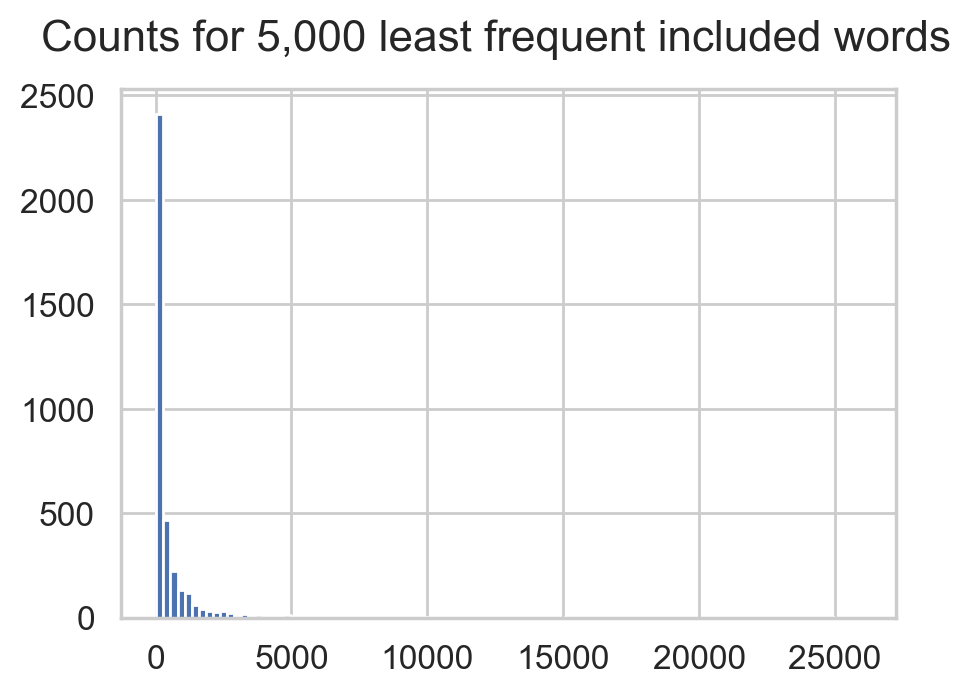

,id,token,count
3118,3994,mere,30
2356,2785,toilet_shower,30
3292,4309,toy,30
2225,2618,store_bag,30
1488,1684,las_vega,30
2126,2494,sophist,30
1263,1419,date,30
3360,4443,tiffani,31
2336,2760,establish,31
2765,3432,tank,31


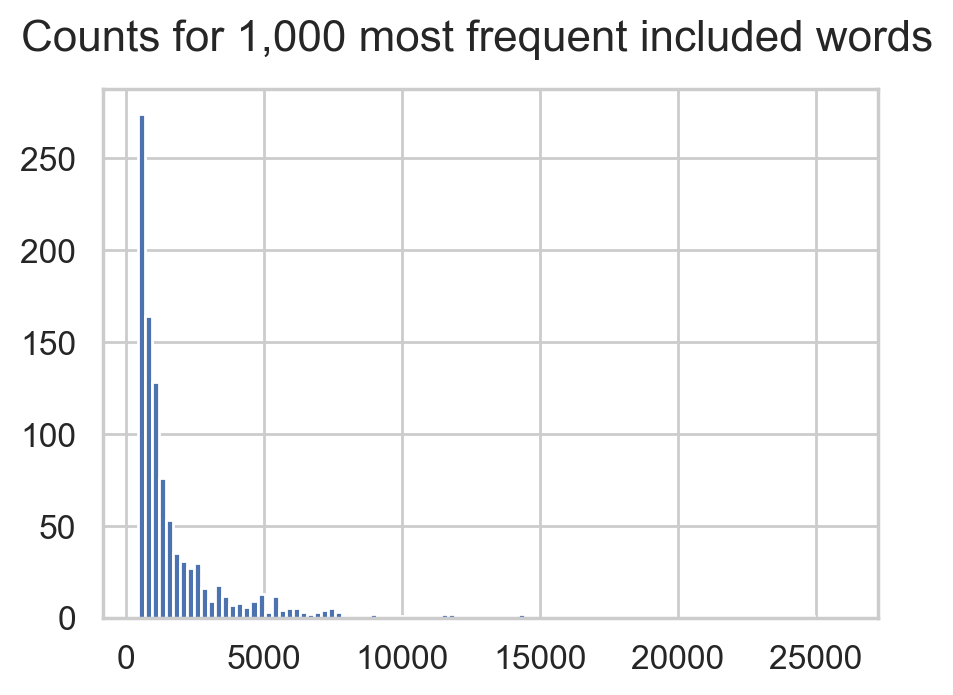

,id,token,count
256,280,holiday_inn,6855
78,86,day,6884
463,506,tradit,6934
75,82,children,7151
328,362,good_valu,7171
21,22,needl,7199
406,444,class,7204
189,202,offer,7338
207,222,twice,7396
97,105,place,7402


In [11]:
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below=30, no_above=0.5, keep_n=20000)

# Look at the top 100 and bottom 100 tokens

temp = dictionary[0]  # Initialize the dict

token_counts = pd.DataFrame(np.array(
    [[token_id, dictionary.id2token[token_id], dictionary.cfs[token_id]]
     for token_id in dictionary.keys()
     if token_id in dictionary.cfs.keys() and token_id in dictionary.id2token.keys()
     ]
), columns=['id', 'token', 'count'])

token_counts['count'] = token_counts['count'].astype('int')
token_counts['count'].describe()
token_counts = token_counts.sort_values('count')

plt.rcParams.update({'figure.figsize': (5, 3.5), 'figure.dpi': 200})
token_counts['count'].head(5000).hist(bins=100)
plt.suptitle("Counts for 5,000 least frequent included words")
plt.show()
display(token_counts.head(50))

plt.rcParams.update({'figure.figsize': (5, 3.5), 'figure.dpi': 200})
token_counts['count'].tail(1000).hist(bins=100)
plt.suptitle("Counts for 1,000 most frequent included words")
plt.show()
display(token_counts.tail(50))

In [12]:
# Replace the split data with the data updated with phrases
display(happy_tokens.shape, bad_tokens.shape)
happy_tokens = all_tokens.iloc[:len(happy_tokens)].copy().reset_index(drop=True)
bad_tokens = all_tokens.iloc[len(happy_tokens):].copy().reset_index(drop=True)
display(happy_tokens.shape, bad_tokens.shape)

(26521,)

(12411,)

(26521,)

(12411,)

### Look at two examples before and after preprocessing

In [13]:
happy_idx = np.random.randint(1, len(happy_tokens))
bad_idx = np.random.randint(1, len(bad_tokens))

print('HAPPY before:')
display(happy_reviews['Description'].iloc[happy_idx])
print('HAPPY after:')
display(happy_tokens.iloc[happy_idx])

print('NOT HAPPY before:')
display(bad_reviews['Description'].iloc[bad_idx])
print('NOT HAPPY after:')
display(bad_tokens.iloc[bad_idx])

HAPPY before:


'We booked this through our time share, and were pleasantly surprised at the space provided. We had a noise issue the first night, which was immediately rectified by the hotel manager and staff. We were upgraded to an even larger room. The bathrooms were on the small side and could use towel bars. We wish there was a """"""""""""""""""""""""""""""""down"""""""""""""""""""""""""""""""" escalator to make it easier to transport our suitcases as we left the hotel. The bed was very comfortable. Kitchenette was a nice addition. A great place to relax after a long day running around the city sites. We would definitely book this again!'

HAPPY after:


['book',
 'time',
 'share',
 'pleasant',
 'surpris',
 'space',
 'provid',
 'nois',
 'issu',
 'night',
 'immedi',
 'rectifi',
 'hotel',
 'manag',
 'staff',
 'upgrad',
 'larger',
 'room',
 'bathroom',
 'small',
 'use',
 'towel',
 'bar',
 'wish',
 'escal',
 'easier',
 'transport',
 'suitcas',
 'leav',
 'hotel',
 'bed',
 'veri',
 'comfort',
 'kitchenett',
 'nice',
 'addit',
 'great',
 'place',
 'relax',
 'long',
 'day',
 'run',
 'citi',
 'sit',
 'definit',
 'book',
 'pleasant_surpris',
 'upgrad_larger']

NOT HAPPY before:


"Some problems with the stay that really bring this score down:\n- NO Parking, no recommendations, no help. Wound up parking at the nearest garage at $-- per day.\n- Pulled up and had to get a luggage cart myself, unload luggage, get it in the building, up the elevator (more on that later) and to the room, get the cart back down and get the car moved from the temp parking out front.\n- Absolutely no help from staff. The desk told me to move my car quickly at check-in, or it would be ticketed. There is no bellman, the concierge is a joke and you have to pay $- per half hour for the internet.\n- Only two elevators were in service, so getting up from the lobby wasn't bad, but by the second day of our stay, we quit trying to wait to go down and just walked the -- flights with the kids and stroller.\n- The rooms were fine, if a little on the stale side.\n- The Upper West Side location is convenient.\nI would not stay at this hotel again.\nI would recommend it for school trips and the like."

NOT HAPPY after:


['problem',
 'stay',
 'realli',
 'bring',
 'score',
 'park',
 'recommend',
 'help',
 'wind',
 'park',
 'nearest',
 'garag',
 'day',
 'pull',
 'luggag',
 'cart',
 'unload',
 'luggag',
 'build',
 'elev',
 'later',
 'room',
 'cart',
 'car',
 'temp',
 'park',
 'absolut',
 'help',
 'staff',
 'desk',
 'tell',
 'car',
 'quick',
 'check',
 'ticket',
 'bellman',
 'concierg',
 'joke',
 'pay',
 'half',
 'hour',
 'internet',
 'onli',
 'elev',
 'servic',
 'lobbi',
 'wasn',
 'bad',
 'second',
 'day',
 'stay',
 'quit',
 'tri',
 'wait',
 'walk',
 'flight',
 'kid',
 'stroller',
 'room',
 'fine',
 'littl',
 'stale',
 'upper',
 'west',
 'locat',
 'conveni',
 'stay',
 'hotel',
 'recommend',
 'school',
 'trip',
 'like',
 'luggag_cart',
 'unload_luggag',
 'half_hour',
 'wasn_bad',
 'upper_west']

### Vectorize with Bag of Words and TF-IDF

In [14]:
bow_corpus = [dictionary.doc2bow(review) for review in all_tokens]
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]
print('Number of unique tokens: {}'.format(len(dictionary)))
print('Number of documents: {}'.format(len(bow_corpus)))
len(tfidf_corpus)

2020-04-09 15:32:02,623 : INFO : collecting document frequencies


2020-04-09 15:32:02,624 : INFO : PROGRESS: processing document #0


2020-04-09 15:32:02,698 : INFO : PROGRESS: processing document #10000


2020-04-09 15:32:02,777 : INFO : PROGRESS: processing document #20000


2020-04-09 15:32:02,866 : INFO : PROGRESS: processing document #30000


2020-04-09 15:32:02,950 : INFO : calculating IDF weights for 38932 documents and 5158 features (2138190 matrix non-zeros)


Number of unique tokens: 5158
Number of documents: 38932


38932

## LDA topic modeling

In [15]:
# Fit a single version of the LDA model.
num_topics = 10
chunksize = 5000
passes = 4
iterations = 200
eval_every = 1  # Evaluate convergence at the end

id2word = dictionary.id2token

lda_model = LdaMulticore(
    corpus=tfidf_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='symmetric',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    workers=4  # Use all four cores
)

top_topics = lda_model.top_topics(tfidf_corpus)
pprint(top_topics)

2020-04-09 15:32:02,990 : INFO : using symmetric alpha at 0.1


2020-04-09 15:32:02,991 : INFO : using serial LDA version on this node


2020-04-09 15:32:02,997 : INFO : running online LDA training, 10 topics, 4 passes over the supplied corpus of 38932 documents, updating every 20000 documents, evaluating every ~20000 documents, iterating 200x with a convergence threshold of 0.001000


2020-04-09 15:32:02,997 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


2020-04-09 15:32:03,017 : INFO : training LDA model using 4 processes


2020-04-09 15:32:04,915 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #5000/38932, outstanding queue size 1


2020-04-09 15:32:07,116 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #10000/38932, outstanding queue size 2


2020-04-09 15:32:09,212 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #15000/38932, outstanding queue size 2


2020-04-09 15:32:11,349 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #20000/38932, outstanding queue size 2


2020-04-09 15:32:13,492 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #25000/38932, outstanding queue size 2


2020-04-09 15:32:14,382 : DEBUG : updating topics


2020-04-09 15:32:14,385 : INFO : merging changes from 20000 documents into a model of 38932 documents


2020-04-09 15:32:14,389 : INFO : topic #1 (0.100): 0.005*"great" + 0.003*"nice" + 0.003*"good" + 0.003*"love" + 0.003*"friend" + 0.003*"staff" + 0.003*"servic" + 0.003*"clean" + 0.003*"locat" + 0.003*"restaur"


2020-04-09 15:32:14,390 : INFO : topic #6 (0.100): 0.004*"great" + 0.004*"excel" + 0.004*"nice" + 0.003*"staff" + 0.003*"servic" + 0.003*"clean" + 0.003*"friend" + 0.003*"good" + 0.003*"locat" + 0.003*"comfort"


2020-04-09 15:32:14,391 : INFO : topic #3 (0.100): 0.005*"great" + 0.004*"nice" + 0.004*"friend" + 0.004*"staff" + 0.003*"good" + 0.003*"breakfast" + 0.003*"clean" + 0.003*"help" + 0.003*"time" + 0.003*"locat"


2020-04-09 15:32:14,391 : INFO : topic #5 (0.100): 0.005*"great" + 0.004*"staff" + 0.003*"locat" + 0.003*"help" + 0.003*"good" + 0.003*"friend" + 0.003*"nice" + 0.003*"clean" + 0.003*"love" + 0.003*"servic"


2020-04-09 15:32:14,392 : INFO : topic #0 (0.100): 0.005*"great" + 0.003*"nice" + 0.003*"good" + 0.003*"clean" + 0.003*"servic" + 0.003*"locat" + 0.003*"help" + 0.003*"staff" + 0.003*"restaur" + 0.003*"time"


2020-04-09 15:32:14,393 : INFO : topic diff=2.132908, rho=1.000000


2020-04-09 15:32:14,439 : DEBUG : bound: at document #0


2020-04-09 15:32:17,655 : INFO : -8.684 per-word bound, 411.3 perplexity estimate based on a held-out corpus of 5000 documents with 30267 words


2020-04-09 15:32:19,060 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #30000/38932, outstanding queue size 2


2020-04-09 15:32:21,480 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #35000/38932, outstanding queue size 2


2020-04-09 15:32:23,605 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #38932/38932, outstanding queue size 3


2020-04-09 15:32:26,626 : DEBUG : updating topics


2020-04-09 15:32:26,628 : INFO : merging changes from 18932 documents into a model of 38932 documents


2020-04-09 15:32:26,631 : INFO : topic #4 (0.100): 0.004*"great" + 0.003*"nice" + 0.003*"walk" + 0.003*"place" + 0.003*"clean" + 0.003*"locat" + 0.003*"friend" + 0.003*"staff" + 0.003*"good" + 0.003*"servic"


2020-04-09 15:32:26,632 : INFO : topic #0 (0.100): 0.004*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"clean" + 0.003*"servic" + 0.003*"locat" + 0.003*"night" + 0.003*"bed" + 0.003*"staff" + 0.003*"time"


2020-04-09 15:32:26,633 : INFO : topic #2 (0.100): 0.003*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"park" + 0.003*"night" + 0.003*"time" + 0.003*"staff" + 0.003*"clean" + 0.003*"onli" + 0.003*"servic"


2020-04-09 15:32:26,633 : INFO : topic #3 (0.100): 0.004*"great" + 0.003*"good" + 0.003*"night" + 0.003*"nice" + 0.003*"time" + 0.003*"breakfast" + 0.003*"servic" + 0.003*"clean" + 0.003*"friend" + 0.003*"staff"


2020-04-09 15:32:26,634 : INFO : topic #7 (0.100): 0.004*"nice" + 0.003*"great" + 0.003*"good" + 0.003*"night" + 0.003*"park" + 0.003*"servic" + 0.003*"breakfast" + 0.003*"place" + 0.003*"time" + 0.003*"staff"


2020-04-09 15:32:26,635 : INFO : topic diff=0.578693, rho=0.447214


2020-04-09 15:32:26,677 : DEBUG : bound: at document #0


2020-04-09 15:32:29,397 : INFO : -8.742 per-word bound, 428.1 perplexity estimate based on a held-out corpus of 3932 documents with 25806 words


2020-04-09 15:32:30,599 : INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #5000/38932, outstanding queue size 1


2020-04-09 15:32:32,690 : INFO : PROGRESS: pass 1, dispatched chunk #1 = documents up to #10000/38932, outstanding queue size 2


2020-04-09 15:32:34,758 : INFO : PROGRESS: pass 1, dispatched chunk #2 = documents up to #15000/38932, outstanding queue size 3


2020-04-09 15:32:36,807 : INFO : PROGRESS: pass 1, dispatched chunk #3 = documents up to #20000/38932, outstanding queue size 2


2020-04-09 15:32:38,861 : INFO : PROGRESS: pass 1, dispatched chunk #4 = documents up to #25000/38932, outstanding queue size 3


2020-04-09 15:32:39,715 : DEBUG : updating topics


2020-04-09 15:32:39,717 : INFO : merging changes from 20000 documents into a model of 38932 documents


2020-04-09 15:32:39,721 : INFO : topic #1 (0.100): 0.004*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"servic" + 0.003*"night" + 0.003*"time" + 0.003*"place" + 0.003*"staff" + 0.003*"walk" + 0.003*"clean"


2020-04-09 15:32:39,722 : INFO : topic #4 (0.100): 0.005*"great" + 0.004*"walk" + 0.003*"nice" + 0.003*"friend" + 0.003*"place" + 0.003*"locat" + 0.003*"clean" + 0.003*"staff" + 0.003*"good" + 0.003*"help"


2020-04-09 15:32:39,723 : INFO : topic #8 (0.100): 0.004*"great" + 0.004*"nice" + 0.003*"staff" + 0.003*"clean" + 0.003*"servic" + 0.003*"locat" + 0.003*"excel" + 0.003*"good" + 0.003*"breakfast" + 0.003*"friend"


2020-04-09 15:32:39,723 : INFO : topic #7 (0.100): 0.004*"nice" + 0.004*"great" + 0.003*"park" + 0.003*"good" + 0.003*"servic" + 0.003*"breakfast" + 0.003*"night" + 0.003*"free" + 0.003*"staff" + 0.003*"clean"


2020-04-09 15:32:39,724 : INFO : topic #3 (0.100): 0.004*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"breakfast" + 0.003*"time" + 0.003*"night" + 0.003*"servic" + 0.003*"staff" + 0.003*"friend" + 0.003*"clean"


2020-04-09 15:32:39,725 : INFO : topic diff=0.233027, rho=0.319660


2020-04-09 15:32:41,121 : INFO : PROGRESS: pass 1, dispatched chunk #5 = documents up to #30000/38932, outstanding queue size 2


2020-04-09 15:32:43,809 : INFO : PROGRESS: pass 1, dispatched chunk #6 = documents up to #35000/38932, outstanding queue size 2


2020-04-09 15:32:45,946 : INFO : PROGRESS: pass 1, dispatched chunk #7 = documents up to #38932/38932, outstanding queue size 2


2020-04-09 15:32:48,695 : DEBUG : updating topics


2020-04-09 15:32:48,698 : INFO : merging changes from 18932 documents into a model of 38932 documents


2020-04-09 15:32:48,702 : INFO : topic #2 (0.100): 0.003*"night" + 0.003*"desk" + 0.003*"good" + 0.003*"onli" + 0.003*"bed" + 0.003*"nice" + 0.003*"check" + 0.003*"time" + 0.003*"bathroom" + 0.003*"like"


2020-04-09 15:32:48,702 : INFO : topic #9 (0.100): 0.004*"great" + 0.003*"walk" + 0.003*"time" + 0.003*"locat" + 0.003*"nice" + 0.003*"good" + 0.003*"clean" + 0.003*"friend" + 0.003*"breakfast" + 0.003*"bed"


2020-04-09 15:32:48,703 : INFO : topic #5 (0.100): 0.005*"great" + 0.004*"staff" + 0.004*"help" + 0.004*"friend" + 0.004*"servic" + 0.004*"clean" + 0.003*"locat" + 0.003*"good" + 0.003*"nice" + 0.003*"wonder"


2020-04-09 15:32:48,704 : INFO : topic #1 (0.100): 0.003*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"night" + 0.003*"place" + 0.003*"servic" + 0.003*"time" + 0.002*"clean" + 0.002*"walk" + 0.002*"locat"


2020-04-09 15:32:48,705 : INFO : topic #4 (0.100): 0.004*"great" + 0.004*"walk" + 0.003*"nice" + 0.003*"locat" + 0.003*"place" + 0.003*"clean" + 0.003*"friend" + 0.003*"staff" + 0.003*"good" + 0.003*"pool"


2020-04-09 15:32:48,705 : INFO : topic diff=0.266215, rho=0.319660


2020-04-09 15:32:48,746 : DEBUG : bound: at document #0


2020-04-09 15:32:51,410 : INFO : -8.631 per-word bound, 396.6 perplexity estimate based on a held-out corpus of 3932 documents with 25806 words


2020-04-09 15:32:52,602 : INFO : PROGRESS: pass 2, dispatched chunk #0 = documents up to #5000/38932, outstanding queue size 1


2020-04-09 15:32:54,669 : INFO : PROGRESS: pass 2, dispatched chunk #1 = documents up to #10000/38932, outstanding queue size 2


2020-04-09 15:32:56,718 : INFO : PROGRESS: pass 2, dispatched chunk #2 = documents up to #15000/38932, outstanding queue size 3


2020-04-09 15:32:58,844 : INFO : PROGRESS: pass 2, dispatched chunk #3 = documents up to #20000/38932, outstanding queue size 3


2020-04-09 15:33:00,996 : INFO : PROGRESS: pass 2, dispatched chunk #4 = documents up to #25000/38932, outstanding queue size 2


2020-04-09 15:33:01,857 : DEBUG : updating topics


2020-04-09 15:33:01,859 : INFO : merging changes from 20000 documents into a model of 38932 documents


2020-04-09 15:33:01,863 : INFO : topic #4 (0.100): 0.005*"great" + 0.004*"walk" + 0.004*"nice" + 0.003*"locat" + 0.003*"pool" + 0.003*"place" + 0.003*"friend" + 0.003*"clean" + 0.003*"staff" + 0.003*"restaur"


2020-04-09 15:33:01,864 : INFO : topic #6 (0.100): 0.004*"great" + 0.004*"nice" + 0.004*"servic" + 0.003*"clean" + 0.003*"friend" + 0.003*"staff" + 0.003*"good" + 0.003*"locat" + 0.003*"excel" + 0.003*"bed"


2020-04-09 15:33:01,865 : INFO : topic #1 (0.100): 0.004*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"place" + 0.003*"night" + 0.003*"servic" + 0.003*"time" + 0.003*"walk" + 0.003*"staff" + 0.003*"restaur"


2020-04-09 15:33:01,866 : INFO : topic #5 (0.100): 0.006*"great" + 0.005*"staff" + 0.005*"help" + 0.005*"friend" + 0.004*"servic" + 0.004*"clean" + 0.004*"wonder" + 0.004*"locat" + 0.004*"love" + 0.004*"good"


2020-04-09 15:33:01,867 : INFO : topic #0 (0.100): 0.005*"wharf" + 0.005*"great" + 0.004*"francisco" + 0.004*"san_francisco" + 0.004*"fisherman" + 0.004*"san" + 0.004*"fisherman_wharf" + 0.004*"car" + 0.004*"good" + 0.004*"cabl_car"


2020-04-09 15:33:01,867 : INFO : topic diff=0.254155, rho=0.304482


2020-04-09 15:33:03,257 : INFO : PROGRESS: pass 2, dispatched chunk #5 = documents up to #30000/38932, outstanding queue size 2


2020-04-09 15:33:05,651 : INFO : PROGRESS: pass 2, dispatched chunk #6 = documents up to #35000/38932, outstanding queue size 2


2020-04-09 15:33:07,754 : INFO : PROGRESS: pass 2, dispatched chunk #7 = documents up to #38932/38932, outstanding queue size 2


2020-04-09 15:33:10,348 : DEBUG : updating topics


2020-04-09 15:33:10,350 : INFO : merging changes from 18932 documents into a model of 38932 documents


2020-04-09 15:33:10,353 : INFO : topic #2 (0.100): 0.003*"night" + 0.003*"desk" + 0.003*"bed" + 0.003*"bathroom" + 0.003*"check" + 0.003*"like" + 0.003*"onli" + 0.003*"floor" + 0.003*"tell" + 0.003*"look"


2020-04-09 15:33:10,354 : INFO : topic #6 (0.100): 0.004*"great" + 0.004*"nice" + 0.004*"servic" + 0.003*"clean" + 0.003*"good" + 0.003*"staff" + 0.003*"friend" + 0.003*"locat" + 0.003*"bed" + 0.003*"excel"


2020-04-09 15:33:10,355 : INFO : topic #5 (0.100): 0.006*"great" + 0.005*"staff" + 0.005*"friend" + 0.005*"help" + 0.005*"servic" + 0.004*"clean" + 0.004*"wonder" + 0.004*"locat" + 0.004*"good" + 0.004*"love"


2020-04-09 15:33:10,356 : INFO : topic #8 (0.100): 0.004*"great" + 0.004*"nice" + 0.004*"good" + 0.004*"clean" + 0.004*"staff" + 0.003*"locat" + 0.003*"servic" + 0.003*"breakfast" + 0.003*"friend" + 0.003*"help"


2020-04-09 15:33:10,356 : INFO : topic #9 (0.100): 0.004*"great" + 0.004*"time" + 0.004*"time_squar" + 0.004*"walk" + 0.004*"squar" + 0.004*"york" + 0.004*"new_york" + 0.003*"locat" + 0.003*"new" + 0.003*"good"


2020-04-09 15:33:10,357 : INFO : topic diff=0.254702, rho=0.304482


2020-04-09 15:33:10,397 : DEBUG : bound: at document #0


2020-04-09 15:33:12,856 : INFO : -8.558 per-word bound, 376.9 perplexity estimate based on a held-out corpus of 3932 documents with 25806 words


2020-04-09 15:33:14,056 : INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #5000/38932, outstanding queue size 1


2020-04-09 15:33:16,120 : INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #10000/38932, outstanding queue size 2


2020-04-09 15:33:18,166 : INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #15000/38932, outstanding queue size 3


2020-04-09 15:33:20,214 : INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #20000/38932, outstanding queue size 3


2020-04-09 15:33:22,274 : INFO : PROGRESS: pass 3, dispatched chunk #4 = documents up to #25000/38932, outstanding queue size 3


2020-04-09 15:33:23,123 : DEBUG : updating topics


2020-04-09 15:33:23,126 : INFO : merging changes from 20000 documents into a model of 38932 documents


2020-04-09 15:33:23,129 : INFO : topic #0 (0.100): 0.007*"francisco" + 0.007*"san_francisco" + 0.007*"wharf" + 0.006*"san" + 0.006*"fisherman" + 0.006*"fisherman_wharf" + 0.005*"union_squar" + 0.005*"cabl_car" + 0.005*"union" + 0.005*"car"


2020-04-09 15:33:23,130 : INFO : topic #4 (0.100): 0.005*"great" + 0.004*"walk" + 0.004*"pool" + 0.004*"nice" + 0.004*"boston" + 0.004*"locat" + 0.003*"restaur" + 0.003*"friend" + 0.003*"place" + 0.003*"view"


2020-04-09 15:33:23,131 : INFO : topic #7 (0.100): 0.004*"park" + 0.004*"nice" + 0.003*"free" + 0.003*"good" + 0.003*"breakfast" + 0.003*"servic" + 0.003*"great" + 0.003*"night" + 0.003*"airport" + 0.003*"check"


2020-04-09 15:33:23,132 : INFO : topic #1 (0.100): 0.004*"great" + 0.003*"nice" + 0.003*"good" + 0.003*"place" + 0.003*"night" + 0.003*"servic" + 0.003*"area" + 0.003*"pool" + 0.003*"restaur" + 0.003*"walk"


2020-04-09 15:33:23,132 : INFO : topic #2 (0.100): 0.003*"night" + 0.003*"bed" + 0.003*"desk" + 0.003*"bathroom" + 0.003*"onli" + 0.003*"check" + 0.003*"like" + 0.003*"floor" + 0.003*"good" + 0.003*"nice"


2020-04-09 15:33:23,133 : INFO : topic diff=0.260190, rho=0.291279


2020-04-09 15:33:24,510 : INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #30000/38932, outstanding queue size 2


2020-04-09 15:33:26,919 : INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #35000/38932, outstanding queue size 2


2020-04-09 15:33:29,021 : INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #38932/38932, outstanding queue size 2


2020-04-09 15:33:31,498 : DEBUG : updating topics


2020-04-09 15:33:31,501 : INFO : merging changes from 18932 documents into a model of 38932 documents


2020-04-09 15:33:31,504 : INFO : topic #9 (0.100): 0.005*"time_squar" + 0.004*"squar" + 0.004*"york" + 0.004*"new_york" + 0.004*"time" + 0.004*"great" + 0.004*"new" + 0.004*"walk" + 0.004*"locat" + 0.004*"central"


2020-04-09 15:33:31,505 : INFO : topic #3 (0.100): 0.003*"check" + 0.003*"servic" + 0.003*"night" + 0.003*"breakfast" + 0.003*"time" + 0.003*"great" + 0.003*"day" + 0.003*"good" + 0.003*"nice" + 0.003*"manag"


2020-04-09 15:33:31,506 : INFO : topic #1 (0.100): 0.003*"great" + 0.003*"good" + 0.003*"nice" + 0.003*"place" + 0.003*"area" + 0.003*"night" + 0.003*"pool" + 0.003*"servic" + 0.003*"hollywood" + 0.003*"walk"


2020-04-09 15:33:31,506 : INFO : topic #4 (0.100): 0.005*"great" + 0.004*"walk" + 0.004*"pool" + 0.004*"nice" + 0.004*"boston" + 0.004*"diego" + 0.004*"san_diego" + 0.004*"locat" + 0.003*"downtown" + 0.003*"restaur"


2020-04-09 15:33:31,507 : INFO : topic #0 (0.100): 0.007*"francisco" + 0.007*"san_francisco" + 0.007*"wharf" + 0.007*"san" + 0.006*"fisherman" + 0.006*"union_squar" + 0.006*"union" + 0.006*"fisherman_wharf" + 0.006*"cabl_car" + 0.006*"cabl"


2020-04-09 15:33:31,508 : INFO : topic diff=0.245524, rho=0.291279


2020-04-09 15:33:31,551 : DEBUG : bound: at document #0


2020-04-09 15:33:34,011 : INFO : -8.518 per-word bound, 366.5 perplexity estimate based on a held-out corpus of 3932 documents with 25806 words


2020-04-09 15:33:34,054 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=5158, num_topics=10, decay=0.5, chunksize=5000)


2020-04-09 15:33:34,310 : INFO : CorpusAccumulator accumulated stats from 1000 documents


2020-04-09 15:33:34,574 : INFO : CorpusAccumulator accumulated stats from 2000 documents


2020-04-09 15:33:34,820 : INFO : CorpusAccumulator accumulated stats from 3000 documents


2020-04-09 15:33:35,078 : INFO : CorpusAccumulator accumulated stats from 4000 documents


2020-04-09 15:33:35,336 : INFO : CorpusAccumulator accumulated stats from 5000 documents


2020-04-09 15:33:35,592 : INFO : CorpusAccumulator accumulated stats from 6000 documents


2020-04-09 15:33:35,843 : INFO : CorpusAccumulator accumulated stats from 7000 documents


2020-04-09 15:33:36,102 : INFO : CorpusAccumulator accumulated stats from 8000 documents


2020-04-09 15:33:36,359 : INFO : CorpusAccumulator accumulated stats from 9000 documents


2020-04-09 15:33:36,637 : INFO : CorpusAccumulator accumulated stats from 10000 documents


2020-04-09 15:33:36,929 : INFO : CorpusAccumulator accumulated stats from 11000 documents


2020-04-09 15:33:37,175 : INFO : CorpusAccumulator accumulated stats from 12000 documents


2020-04-09 15:33:37,419 : INFO : CorpusAccumulator accumulated stats from 13000 documents


2020-04-09 15:33:37,675 : INFO : CorpusAccumulator accumulated stats from 14000 documents


2020-04-09 15:33:37,957 : INFO : CorpusAccumulator accumulated stats from 15000 documents


2020-04-09 15:33:38,218 : INFO : CorpusAccumulator accumulated stats from 16000 documents


2020-04-09 15:33:38,492 : INFO : CorpusAccumulator accumulated stats from 17000 documents


2020-04-09 15:33:38,744 : INFO : CorpusAccumulator accumulated stats from 18000 documents


2020-04-09 15:33:38,984 : INFO : CorpusAccumulator accumulated stats from 19000 documents


2020-04-09 15:33:39,234 : INFO : CorpusAccumulator accumulated stats from 20000 documents


2020-04-09 15:33:39,492 : INFO : CorpusAccumulator accumulated stats from 21000 documents


2020-04-09 15:33:39,746 : INFO : CorpusAccumulator accumulated stats from 22000 documents


2020-04-09 15:33:39,991 : INFO : CorpusAccumulator accumulated stats from 23000 documents


2020-04-09 15:33:40,248 : INFO : CorpusAccumulator accumulated stats from 24000 documents


2020-04-09 15:33:40,506 : INFO : CorpusAccumulator accumulated stats from 25000 documents


2020-04-09 15:33:40,767 : INFO : CorpusAccumulator accumulated stats from 26000 documents


2020-04-09 15:33:41,041 : INFO : CorpusAccumulator accumulated stats from 27000 documents


2020-04-09 15:33:41,357 : INFO : CorpusAccumulator accumulated stats from 28000 documents


2020-04-09 15:33:41,653 : INFO : CorpusAccumulator accumulated stats from 29000 documents


2020-04-09 15:33:41,988 : INFO : CorpusAccumulator accumulated stats from 30000 documents


2020-04-09 15:33:42,284 : INFO : CorpusAccumulator accumulated stats from 31000 documents


2020-04-09 15:33:42,569 : INFO : CorpusAccumulator accumulated stats from 32000 documents


2020-04-09 15:33:42,852 : INFO : CorpusAccumulator accumulated stats from 33000 documents


2020-04-09 15:33:43,147 : INFO : CorpusAccumulator accumulated stats from 34000 documents


2020-04-09 15:33:43,488 : INFO : CorpusAccumulator accumulated stats from 35000 documents


2020-04-09 15:33:43,976 : INFO : CorpusAccumulator accumulated stats from 36000 documents


2020-04-09 15:33:44,280 : INFO : CorpusAccumulator accumulated stats from 37000 documents


2020-04-09 15:33:44,610 : INFO : CorpusAccumulator accumulated stats from 38000 documents


[([(0.0074475068, 'francisco'),
   (0.0074176616, 'san_francisco'),
   (0.007185718, 'wharf'),
   (0.0067427317, 'san'),
   (0.0063048126, 'fisherman'),
   (0.0061336113, 'union_squar'),
   (0.0061162184, 'union'),
   (0.00607426, 'fisherman_wharf'),
   (0.0058667976, 'cabl_car'),
   (0.00552883, 'cabl'),
   (0.0054601426, 'car'),
   (0.0046561854, 'great'),
   (0.004455996, 'squar'),
   (0.0042749196, 'locat'),
   (0.004166036, 'good'),
   (0.00398867, 'walk'),
   (0.0035924974, 'clean'),
   (0.0035348227, 'nice'),
   (0.0033935113, 'street'),
   (0.0033258386, 'help')],
  -1.0413497292363505),
 ([(0.0046636434, 'time_squar'),
   (0.0044350214, 'squar'),
   (0.00426797, 'york'),
   (0.0042653205, 'new_york'),
   (0.004235688, 'time'),
   (0.004154865, 'great'),
   (0.004008998, 'new'),
   (0.0038969822, 'walk'),
   (0.0036579226, 'locat'),
   (0.0036499186, 'central'),
   (0.003607484, 'nyc'),
   (0.0035240422, 'subway'),
   (0.0034530605, 'good'),
   (0.0031566797, 'clean'),
   (0.00

Gensim calculates the [intrinsic coherence score](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) for
each topic. By averaging across all of the topics in the model you can get an average coherence score. Coherence
is a measure of the strength of the association between words in a topic cluster. It is supposed to be an objective
way to evaluate the quailty of the topic clusters. Higher scores are better.

In [16]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.2838.


References:
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [17]:
# This code is used to run the .py script from beginning to end in the python interpreter
# with open('python/happy_hotel.py', 'r') as f:
#     exec(f.read())

# plt.close('all')